In [1]:
# Importing the modules and libraries
# Additional libraries should be imported in this cell for organization

from datetime import datetime
import numpy as np
import glob
import os
from numpy import array
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
import matplotlib.dates as mdates
import pandas as pd
from pandas.plotting import autocorrelation_plot
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM
from keras.layers import Bidirectional
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import GridSearchCV
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
import pmdarima as pm
from pmdarima.arima import ADFTest
from dateutil.relativedelta import relativedelta, MO
import matplotlib.dates as mdates
import seaborn as sns
import plotly.express as px

In [2]:
# fix random seed for reproducibility
tf.random.set_seed(7)

# Adjusting the Data
Before we are able to train any ML models, the data must be cleaned and adjusted due to its stochastic and irregular data.

In [ ]:
# Define the folder path where .txt files are stored
folder_path = "Stela_measur"  # Change this to your actual folder path

# Use glob to get all .txt files in the folder
txt_files = glob.glob(os.path.join(folder_path, "*.txt"))

# Create an empty list to store DataFrames
df_list = []

# The column names of the DataFrame to be created
column_names = ["Time", "Tpv", "Tamb", "g", "Vwd"]

# Loop through each .txt file and read it
for file in txt_files:
    df = pd.read_csv(file, delimiter="\t", header=None, names=column_names)  # Read with tab separator, change delimiter if separator is different
    df["Date"] = os.path.basename(file)  # Add a new column with the file name
    df = df.drop([0])
    df_list.append(df)  # Append to the list

# Concatenate all DataFrames into one big DataFrame
df_Stella_All = pd.concat(df_list, ignore_index=True)

# Display the first few rows
print(df_Stella_All.head())

       Time  Tpv Tamb    g  Vwd          Date
0  00:02:13  NaN  NaN  NaN  NaN  20240101.txt
1  00:05:59    7    9    2    3  20240101.txt
2  00:10:13    7    9    0    2  20240101.txt
3  01:17:40    6    9    0    1  20240101.txt
4  01:22:13    6    9    0    3  20240101.txt


In [ ]:
# move the 'Date' column to the first position in the DataFrame
date_col = df_Stella_All.pop('Date')
df_Stella_All.insert(0, 'Date', date_col)

# Drop NaN values / Change the 'NaN' string to actual NaN values first
df_Stella_All = df_Stella_All.replace('NaN', np.nan)
df_Stella_All = df_Stella_All.dropna()

# Create a copy of the DataFrame
df_Stella_copy = df_Stella_All

# Change the following values to the indices in which the date's property ends
year = 4 # Index in which year ends
month = 6 # Index in which month ends
day = 8 # Index in which day ends
df_Stella_copy['Date'] = df_Stella_copy['Date'].str[:year] + ':' + df_Stella_copy['Date'].str[year:month] + ':' + df_Stella_copy['Date'].str[month:day] + ':'
df_Stella_copy['d&t'] = df_Stella_copy['Date'] + df_Stella_copy['Time']

# move the 'd&t' column to the first position in the DataFrame
date_col = df_Stella_copy.pop('d&t')
df_Stella_copy.insert(0, 'd&t', date_col)

df_Stella_copy.pop('Date')
df_Stella_copy.pop('Time')
df_Stella_copy['d&t'] = pd.to_datetime(df_Stella_copy['d&t'].str.replace(':', ''), format='%Y%m%d%H%M%S', infer_datetime_format=True)
df_Stella_copy = df_Stella_copy.set_index(['d&t'])
df_Stella_copy

C:\Users\ugurhan\AppData\Local\Temp\ipykernel_17448\759862304.py:20: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df_Stella_copy['d&t'] = pd.to_datetime(df_Stella_copy['d&t'].str.replace(':', ''), format='%Y%m%d%H%M%S', infer_datetime_format=True)


,Tpv,Tamb,g,Vwd
d&t,,,,
2024-01-01 00:05:59,7,9,2,3
2024-01-01 00:10:13,7,9,0,2
2024-01-01 01:17:40,6,9,0,1
2024-01-01 01:22:13,6,9,0,3
2024-01-01 02:33:08,6,9,1,4
...,...,...,...,...
2025-02-10 23:59:16,3,3,0,0
2025-02-10 23:59:27,3,3,1,0
2025-02-10 23:59:37,2,3,0,0


With the data now cleaned from the NULL values, and with its 'Date' object specified, we can try handling the irregular data.

In [5]:
# Using to_numeric() method with downcasting
df_Stella_copy['Tpv'] = pd.to_numeric(df_Stella_copy['Tpv'], downcast='integer', errors='coerce')
df_Stella_copy['Tamb'] = pd.to_numeric(df_Stella_copy['Tamb'], downcast='integer', errors='coerce')
df_Stella_copy['g'] = pd.to_numeric(df_Stella_copy['g'], downcast='integer', errors='coerce')
df_Stella_copy['Vwd'] = pd.to_numeric(df_Stella_copy['Vwd'], downcast='integer', errors='coerce')

array([<Axes: xlabel='d&t'>, <Axes: xlabel='d&t'>, <Axes: xlabel='d&t'>,
       <Axes: xlabel='d&t'>], dtype=object)

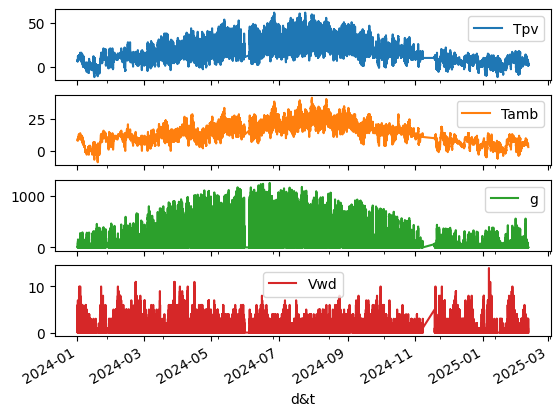

In [6]:
df_Stella_copy.plot(subplots=True)

In [7]:
# Resample to 10-minute intervals, taking the mean of available values
df_resampled = df_Stella_copy.resample('10T').mean()

# Interpolate missing values linearly
df_resampled = df_resampled.interpolate(method='linear')

# Display the first few rows
print(df_resampled.head())

C:\Users\ugurhan\AppData\Local\Temp\ipykernel_17448\3115702731.py:2: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_resampled = df_Stella_copy.resample('10T').mean()


                          Tpv  Tamb    g       Vwd
d&t                                               
2024-01-01 00:00:00  7.000000   9.0  2.0  3.000000
2024-01-01 00:10:00  7.000000   9.0  0.0  2.000000
2024-01-01 00:20:00  6.833333   9.0  0.0  1.833333
2024-01-01 00:30:00  6.666667   9.0  0.0  1.666667
2024-01-01 00:40:00  6.500000   9.0  0.0  1.500000


array([<Axes: xlabel='d&t'>, <Axes: xlabel='d&t'>, <Axes: xlabel='d&t'>,
       <Axes: xlabel='d&t'>], dtype=object)

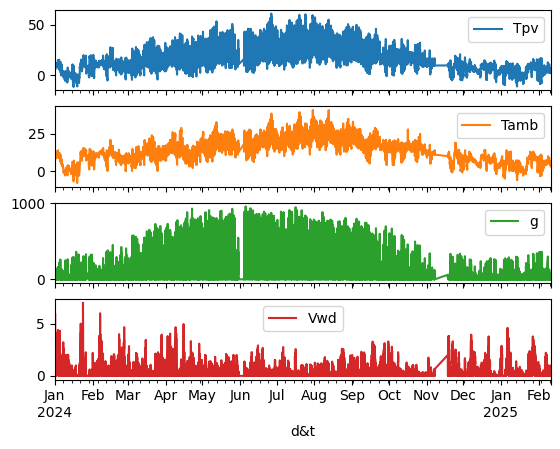

In [8]:
df_resampled.plot(subplots=True)

There are two things we have done to create a suitable dataset for our experiments: <br>
1) <strong>Resampling:</strong> By resampling the data to regular 10 minute intervals, the dataset will be organized and able to be used for training Machine Learning models. <br>
2) <strong>Interpolation:</strong> Since the time intervals of the original data were irregular, some rows with 'NULL' values were created after the resampling process since there were more than 10 minutes between some data values. To fix this, the dataset was interpolated to fill the 'NULL' values with rough estimates.

# Necessary Functions (Dynamic Forecasting)

In [9]:
# convert history into inputs and outputs
def to_supervised(train, n_input, n_out):
	# flatten data
	data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
	X, y = list(), list()
	in_start = 0
	# step over the entire history one time step at a time
	for _ in range(len(data)):
		# define the end of the input sequence
		in_end = in_start + n_input
		out_end = in_end + n_out
		# ensure we have enough data for this instance
		if out_end <= len(data):
			X.append(data[in_start:in_end, :])
			y.append(data[in_end:out_end, 0]) # Whichever feature needs to be predicted
		# move along one time step
		in_start += 1
	return array(X), array(y)

In [ ]:
# Main forecasting function
def forecast(model, history, n_input):
	# flatten data
	data = array(history)
	# data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
	# retrieve last observations for input data
	input_x = data[-n_input:, :]

	# reshape into [1, n_input, n]
	input_x = input_x.reshape((1, input_x.shape[0], input_x.shape[1]))
	# forecast the next week
	yhat = model.predict(input_x, verbose=0)

	# we only want the vector forecast
	yhat = yhat[0]
	return yhat

In [ ]:
# Reframe the datasets into adjusted lengths to later convert them into supervized datasets
def reframe_datasets(training, testing, n_input):

	# restructure into windows of hourly data
	train = array(np.split(training, len(training)/n_input))
	test = array(np.split(testing, len(testing)/n_input))

	return train, test

In [12]:
# train the model
def build_model(train, n_input, n_output):
	# prepare data
	train_x, train_y = to_supervised(train, n_input, n_output)

	# define parameters
	verbose, epochs, batch_size = 2, 150, 288
	n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
	# reshape output into [samples, timesteps, features]
	train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
	# define model
	model = Sequential()
	model.add(LSTM(256, activation='relu', input_shape=(n_timesteps, n_features)))
	model.add(RepeatVector(n_outputs))
	model.add(LSTM(256, activation='relu', return_sequences=True))
	model.add(TimeDistributed(Dense(1)))
	model.compile(loss='mse', optimizer='adam')
	# fit network
	model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
	return model

In [13]:
# Evaluate forecasts against expected values
def evaluate_forecasts(actual, predicted):
	scores = list()

	"""
	# Debugging
	print(np.shape(actual))
	print("")
	print(np.shape(predicted))
	print("")
	print(np.shape(actual[:, 0]))
	print("")
	print(np.shape(predicted[:, 0]))
	print("")
	print(actual.shape[1])
	"""

	# calculate an RMSE score for each day
	for i in range(actual.shape[1]):
		# calculate mse
		mse = mean_squared_error(actual[:, i], predicted[:-1, i])
		# calculate rmse
		rmse = np.sqrt(mse)
		# store
		scores.append(rmse)
	# calculate overall RMSE
	s = 0
	for row in range(actual.shape[0]):
		for col in range(actual.shape[1]):
			s += (actual[row, col] - predicted[row, col])**2
	score = np.sqrt(s / (actual.shape[0] * actual.shape[1]))
	return score, scores

In [ ]:
# Main forecasting function for dynamic forecasting
def forecast_dynamic(model, history, n_input, interval_count):
	# flatten data
	data = array(history)
	# data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
	# retrieve last observations for input data
	input_x = data[-n_input:, :]

	# reshape into [1, n_input, n]
	input_x = input_x.reshape((1, input_x.shape[0], input_x.shape[1]))
	# forecast the next week
	yhat = model.predict(input_x, verbose=0)

	# we only want the vector forecast
	yhat = yhat[0][interval_count-1:interval_count]
	return yhat

In [ ]:
# evaluate a single model for dynamic forecasting
def evaluate_model_dynamic(model, train, test, test_dynamic, n_input):

	dynamic_values = list()
	dynamic_count = 0
	k = 0

	while (k <= len(test_dynamic)):
		if dynamic_count <= 72:
			dynamic_values.append(test_dynamic[k:k+1])
			k += 1
		elif dynamic_count <= (72 + 72):
			dynamic_values.append(test_dynamic[k:k+1])
			k += 3
		else:
			dynamic_values.append(test_dynamic[k:k+1])
			k += 6
		dynamic_count += 1

	dynamic_values = array(dynamic_values)
	dynamic_values = dynamic_values.astype('float32')
	dynamic_values = dynamic_values.reshape((dynamic_values.shape[0]*dynamic_values.shape[1], dynamic_values.shape[2]))
	scaler_dynamic = MinMaxScaler(feature_range=(0, 1))
	test_dynamic = scaler_dynamic.fit_transform(dynamic_values)

	# history is a list of daily data
	history = [x for x in train]

	history = np.array(history)

	history = history.reshape((history.shape[0]*history.shape[1], history.shape[2]))

	# Reshape `test` before inverse transform
	n_samples, n_timesteps, n_features = test.shape
	test_reshaped = test.reshape(n_samples * n_timesteps, n_features)

	# walk-forward validation over each day
	predictions = list()

	i = 0
	interval_count = 0
	prediction_count = 0 # To track how many predictions we have made

	while (i <= len(test_reshaped)):

		# Determine n_output dynamically
		if (prediction_count <= 72):
			interval_count = 1  # 10 minute predictions
		elif (prediction_count <= (72 + 72)):
			interval_count = 3  # Every 30 minutes
		else:
			interval_count = 6  # Every 1 hour

		# predict the day
		yhat_sequence = forecast_dynamic(model, history, n_input, interval_count)

		# store the predictions
		predictions.append(yhat_sequence)

		# get real observation and add to history for predicting the next day
		history = np.append(history, test_reshaped[i:i+interval_count,:], axis=0)

		# Calculate completion percentage
		completion_rate = (i + 1) / len(test_reshaped) * 100

		# Print progress on the same line
		print(f'\r{completion_rate:.0f}% complete', end='', flush=True)

		i += interval_count
		prediction_count += 1

	predictions = np.asarray(predictions, dtype="object")

	# evaluate predictions hours for each day
	predictions = array(predictions)

	# Reshape `predictions` before inverse transform
	n_samples = predictions.shape
	predictions_reshaped = predictions.reshape(n_samples[0] * 1, 1)
	
    # Create a scaler for the target feature only
	target_scaler = MinMaxScaler(feature_range=(0, 1))
	
    # Initialize its internal parameters using the ones from the full scaler
	# The scaler must belong to the targeted feature's column
	target_scaler.min_ = scaler_dynamic.min_[0].reshape(1,)
	target_scaler.scale_ = scaler_dynamic.scale_[0].reshape(1,)
	target_scaler.data_min_ = scaler_dynamic.data_min_[0].reshape(1,)
	target_scaler.data_max_ = scaler_dynamic.data_max_[0].reshape(1,)
	target_scaler.data_range_ = scaler_dynamic.data_range_[0].reshape(1,)

	predictions_reshaped = target_scaler.inverse_transform(predictions_reshaped)
	predictions = predictions_reshaped.reshape(n_samples[0], 1, 1)

	n_samples, n_features = test_dynamic.shape
	test_reshaped = scaler_dynamic.inverse_transform(test_dynamic)
		
	test = test_reshaped.reshape(n_samples, n_features, 1)

	return predictions, test

In [16]:
# summarize scores
def summarize_scores(name, score, scores):
	s_scores = ', '.join(['%.1f' % s for s in scores])
	print('%s: [%.3f] %s' % (name, score, s_scores))

# Training the LSTM Model With Dynamic Intervals

In [ ]:
# Select the features to train the model/predict
df_resampled_pv = df_resampled['Tamb']

In [18]:
# Training data
train_df = df_resampled_pv[(df_resampled_pv.index >= '2024-03-01') & (df_resampled_pv.index < '2024-05-01')]
train_df = train_df.to_frame()

# Testing data
test_df = df_resampled_pv[(df_resampled_pv.index >= '2024-05-01') & (df_resampled_pv.index < '2024-06-01')]
test_df = test_df.to_frame()

In [19]:
print(np.shape(train_df))
print(np.shape(test_df))

(8784, 1)
(4464, 1)


In [20]:
# Preparing dataset for LSTM training with dynamic time intervals

df_lstm_training = train_df.values
df_lstm_training = df_lstm_training.astype('float32')

df_lstm_testing = test_df.values
df_lstm_testing = df_lstm_testing.astype('float32')
test_dynamic = df_lstm_testing.astype('float32')

# Normalize the dataset
# Normalizing the dataset is important for problems like the exploding gradient problem

scaler = MinMaxScaler(feature_range=(0, 1))
df_lstm_training = scaler.fit_transform(df_lstm_training)

scaler = MinMaxScaler(feature_range=(0, 1))
df_lstm_testing = scaler.fit_transform(df_lstm_testing)

n_input = 6
n_output = 6
train, test = reframe_datasets(df_lstm_training, df_lstm_testing, n_input)

In [21]:
model_dynamic = build_model(train, n_input, n_output)

d:\Users\ugurhan\Desktop\LSTM Model\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/150
31/31 - 7s - 212ms/step - loss: 0.0585
Epoch 2/150
31/31 - 3s - 87ms/step - loss: 0.0101
Epoch 3/150
31/31 - 3s - 88ms/step - loss: 0.0029
Epoch 4/150
31/31 - 3s - 89ms/step - loss: 0.0021
Epoch 5/150
31/31 - 3s - 90ms/step - loss: 0.0019
Epoch 6/150
31/31 - 3s - 86ms/step - loss: 0.0019
Epoch 7/150
31/31 - 3s - 88ms/step - loss: 0.0018
Epoch 8/150
31/31 - 3s - 87ms/step - loss: 0.0018
Epoch 9/150
31/31 - 3s - 87ms/step - loss: 0.0017
Epoch 10/150
31/31 - 3s - 87ms/step - loss: 0.0016
Epoch 11/150
31/31 - 3s - 87ms/step - loss: 0.0016
Epoch 12/150
31/31 - 3s - 87ms/step - loss: 0.0015
Epoch 13/150
31/31 - 3s - 88ms/step - loss: 0.0014
Epoch 14/150
31/31 - 3s - 90ms/step - loss: 0.0014
Epoch 15/150
31/31 - 3s - 91ms/step - loss: 0.0014
Epoch 16/150
31/31 - 3s - 88ms/step - loss: 0.0013
Epoch 17/150
31/31 - 3s - 88ms/step - loss: 0.0013
Epoch 18/150
31/31 - 3s - 87ms/step - loss: 0.0013
Epoch 19/150
31/31 - 3s - 89ms/step - loss: 0.0012
Epoch 20/150
31/31 - 3s - 87ms/step - l

In [22]:
# Evaluate model and get scores
predictions_dynamic, dynamic_testing = evaluate_model_dynamic(model_dynamic, train, test, test_dynamic, n_input)

100% complete

C:\Users\ugurhan\AppData\Local\Temp\ipykernel_17448\848770319.py:8: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  hourly_dates = pd.date_range(start=start_date, periods=72, freq='10T')  # First 72 points (10 mins)
C:\Users\ugurhan\AppData\Local\Temp\ipykernel_17448\848770319.py:9: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  six_hour_dates = pd.date_range(start=hourly_dates[-1] + pd.Timedelta(hours=3), periods=72, freq='30T')  # Next 72 points (half-hour)
C:\Users\ugurhan\AppData\Local\Temp\ipykernel_17448\848770319.py:10: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  daily_dates = pd.date_range(start=six_hour_dates[-1] + pd.Timedelta(days=6), periods=len(predictions_dynamic)-144, freq='H')  # Remaining points (hourly)


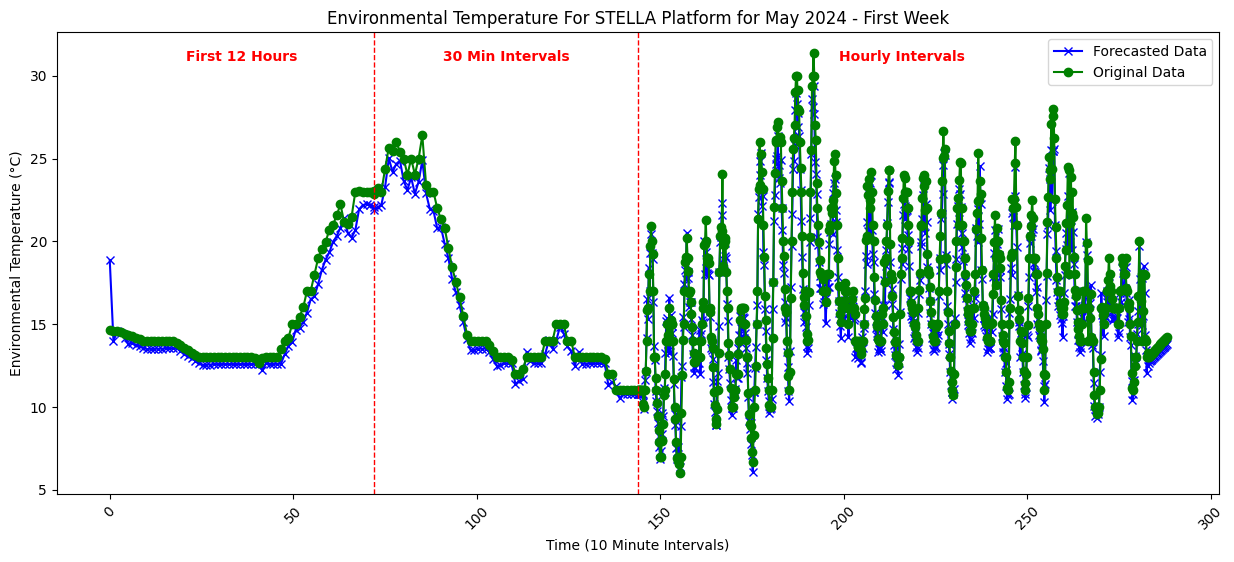

In [23]:
flattened_predictions = predictions_dynamic.flatten()
flattened_test = dynamic_testing[:,0].flatten()

# Assume `start_date` is the first timestamp of your forecast
start_date = pd.Timestamp("2024-05-01")

# Generate corresponding time index
hourly_dates = pd.date_range(start=start_date, periods=72, freq='10T')  # First 72 points (10 mins)
six_hour_dates = pd.date_range(start=hourly_dates[-1] + pd.Timedelta(hours=3), periods=72, freq='30T')  # Next 72 points (half-hour)
daily_dates = pd.date_range(start=six_hour_dates[-1] + pd.Timedelta(days=6), periods=len(predictions_dynamic)-144, freq='H')  # Remaining points (hourly)

# Combine all time indexes
time_index = hourly_dates.append(six_hour_dates).append(daily_dates)

# Manually create a modified x-axis index for readability
x_ticks = np.concatenate([
    np.linspace(0, 72, len(hourly_dates)), 
    np.linspace(72, 144, len(six_hour_dates)), 
    np.linspace(144, 288, len(daily_dates))  
])

# Plot the forecasted values
plt.figure(figsize=(15, 6))
plt.plot(x_ticks, flattened_predictions, marker='x', linestyle='-', color='b', label="Forecasted Data")
plt.plot(x_ticks, flattened_test, marker='o', linestyle='-', color='g', label="Original Data")

# Formatting the x-axis
plt.xlabel("Time (10 Minute Intervals)")
plt.ylabel("Environmental Temperature (°C)")
plt.title("Environmental Temperature For STELLA Platform for May 2024 - First Week")
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.legend()
# plt.grid()

# **Draw vertical lines to separate the intervals**
plt.axvline(x=x_ticks[len(hourly_dates)-1], color='r', linestyle='--', linewidth=1)  # End of hourly interval
plt.axvline(x=x_ticks[len(hourly_dates) + len(six_hour_dates)-1], color='r', linestyle='--', linewidth=1)  # End of 6-hour interval

# **Calculate midpoints for centered text annotations**
mid_hourly = (x_ticks[0] + x_ticks[len(hourly_dates)-1]) / 2
mid_six_hour = (x_ticks[len(hourly_dates)] + x_ticks[len(hourly_dates) + len(six_hour_dates)-1]) / 2
mid_daily = (x_ticks[len(hourly_dates) + len(six_hour_dates)] + x_ticks[-1]) / 2

# **Add text annotations at the center of each interval in bold**
plt.text(mid_hourly, max(flattened_predictions) * 1.05, "First 12 Hours", 
         ha='center', fontsize=10, color='r', fontweight='bold')
plt.text(mid_six_hour, max(flattened_predictions) * 1.05, "30 Min Intervals", 
         ha='center', fontsize=10, color='r', fontweight='bold')
plt.text(mid_daily, max(flattened_predictions) * 1.05, "Hourly Intervals", 
         ha='center', fontsize=10, color='r', fontweight='bold')

# Show the plot
plt.show()

Average RMSE: 0.7427


C:\Users\ugurhan\AppData\Local\Temp\ipykernel_17448\47854730.py:9: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  hourly_dates = pd.date_range(start=start_date, periods=72, freq='10T')  # First 72 points (10 mins)
C:\Users\ugurhan\AppData\Local\Temp\ipykernel_17448\47854730.py:10: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  six_hour_dates = pd.date_range(start=hourly_dates[-1] + pd.Timedelta(hours=3), periods=72, freq='30T')  # Next 96 points (half-hour)
C:\Users\ugurhan\AppData\Local\Temp\ipykernel_17448\47854730.py:11: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  daily_dates = pd.date_range(start=six_hour_dates[-1] + pd.Timedelta(days=6), periods=len(predictions_dynamic)-144, freq='H')  # Remaining points (hourly)


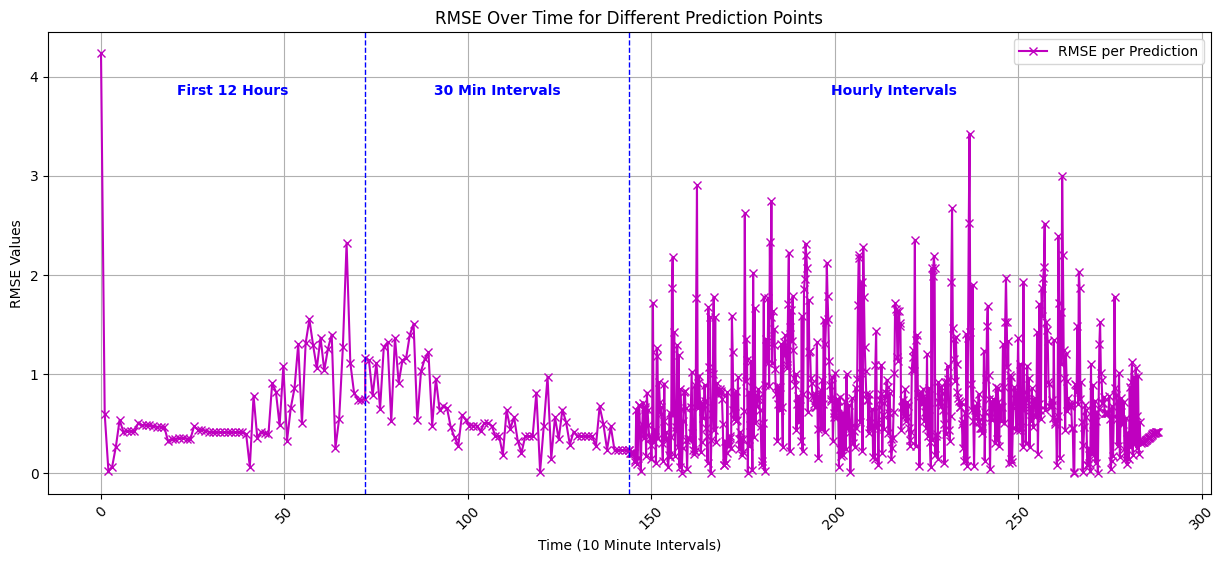

In [24]:
# Compute RMSE for each point
rmse_values = np.sqrt((flattened_predictions - flattened_test) ** 2)

# Compute average RMSE
average_rmse = np.mean(rmse_values)
print(f'Average RMSE: {average_rmse:.4f}')

# Generate custom x-axis spacing
hourly_dates = pd.date_range(start=start_date, periods=72, freq='10T')  # First 72 points (10 mins)
six_hour_dates = pd.date_range(start=hourly_dates[-1] + pd.Timedelta(hours=3), periods=72, freq='30T')  # Next 96 points (half-hour)
daily_dates = pd.date_range(start=six_hour_dates[-1] + pd.Timedelta(days=6), periods=len(predictions_dynamic)-144, freq='H')  # Remaining points (hourly)

# Combine all time indexes
time_index = hourly_dates.append(six_hour_dates).append(daily_dates)

# Manually create a modified x-axis index for readability
x_ticks = np.concatenate([
    np.linspace(0, 72, len(hourly_dates)), 
    np.linspace(72, 144, len(six_hour_dates)), 
    np.linspace(144, 288, len(daily_dates))  
])

# Plot RMSE values
plt.figure(figsize=(15, 6))
plt.plot(x_ticks, rmse_values, marker='x', linestyle='-', color='m', label="RMSE per Prediction")

# Formatting the x-axis
plt.xlabel("Time (10 Minute Intervals)")
plt.ylabel("RMSE Values")
plt.title("RMSE Over Time for Different Prediction Points")
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.legend()
plt.grid()

# Draw vertical dashed lines for intervals
plt.axvline(x=x_ticks[len(hourly_dates)-1], color='b', linestyle='--', linewidth=1)  # End of hourly interval
plt.axvline(x=x_ticks[len(hourly_dates) + len(six_hour_dates)-1], color='b', linestyle='--', linewidth=1)  # End of 6-hour interval

# Calculate midpoints for centered text annotations
mid_hourly = (x_ticks[0] + x_ticks[len(hourly_dates)-1]) / 2
mid_six_hour = (x_ticks[len(hourly_dates)] + x_ticks[len(hourly_dates) + len(six_hour_dates)-1]) / 2
mid_daily = (x_ticks[len(hourly_dates) + len(six_hour_dates)] + x_ticks[-1]) / 2

# Add interval text annotations
plt.text(mid_hourly, max(rmse_values) * 0.90, "First 12 Hours", 
         ha='center', fontsize=10, color='b', fontweight='bold')
plt.text(mid_six_hour, max(rmse_values) * 0.90, "30 Min Intervals", 
         ha='center', fontsize=10, color='b', fontweight='bold')
plt.text(mid_daily, max(rmse_values) * 0.90, "Hourly Intervals", 
         ha='center', fontsize=10, color='b', fontweight='bold')

# Show the RMSE plot
plt.show()

# Training the ARIMA Model With Dynamically Adjusted Time Intervals

In [25]:
# Preparing dataset for LSTM training with dynamic time intervals

df_lstm_training = train_df.values
df_lstm_training = df_lstm_training.astype('float32')

df_lstm_testing = test_df.values
df_lstm_testing = df_lstm_testing.astype('float32')
test_dynamic = df_lstm_testing.astype('float32')

# Normalize the dataset
# Normalizing the dataset is important for problems like the exploding gradient problem

scaler = MinMaxScaler(feature_range=(0, 1))
df_lstm_training = scaler.fit_transform(df_lstm_training)

scaler = MinMaxScaler(feature_range=(0, 1))
df_lstm_testing = scaler.fit_transform(df_lstm_testing)

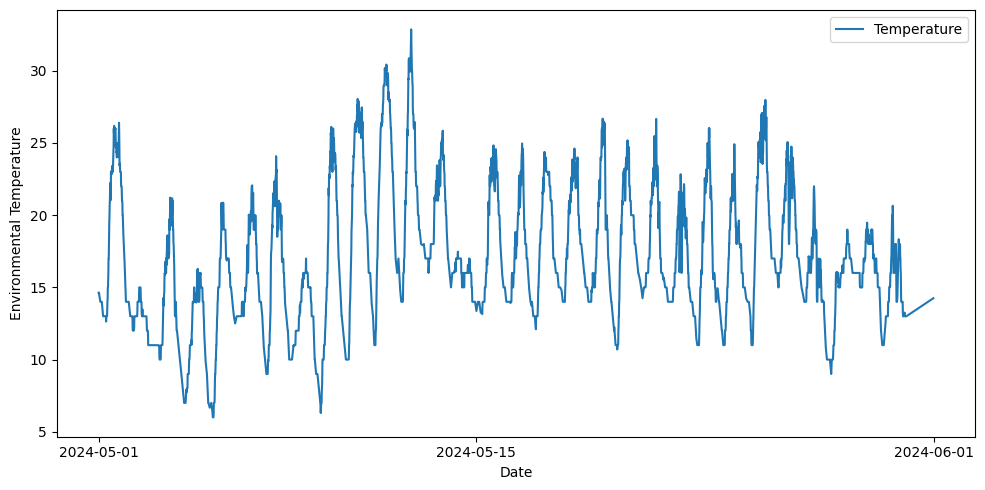

In [26]:
plt.figure(figsize=(10, 5))

plt.plot(test_df, label='Temperature')

# Set major x-axis locator to show only 4 dates
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator(minticks=4, maxticks=4))  # Force 4 labels
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Format as 'YYYY-MM-DD-HH-mm'
plt.xlabel("Date")
plt.ylabel("Environmental Temperature")
plt.legend()
plt.tight_layout()
plt.show()

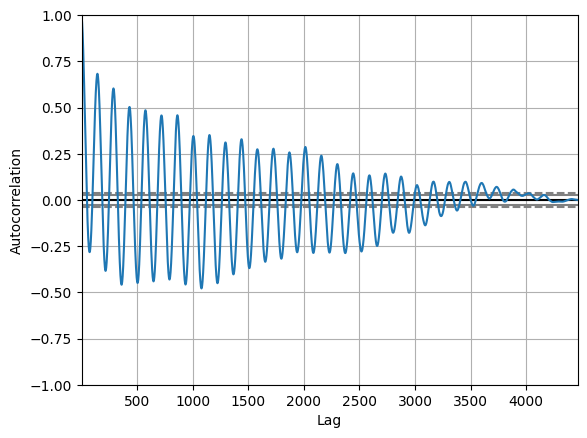

In [27]:
autocorrelation_plot(test_df)
plt.show()

                               SARIMAX Results                                
Dep. Variable:                   Tamb   No. Observations:                 4464
Model:                 ARIMA(6, 1, 0)   Log Likelihood               -2476.066
Date:                Thu, 17 Apr 2025   AIC                           4966.131
Time:                        11:58:36   BIC                           5010.956
Sample:                    05-01-2024   HQIC                          4981.932
                         - 05-31-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2884      0.009     32.388      0.000       0.271       0.306
ar.L2         -0.0127      0.010     -1.303      0.193      -0.032       0.006
ar.L3          0.0474      0.010      4.517      0.0

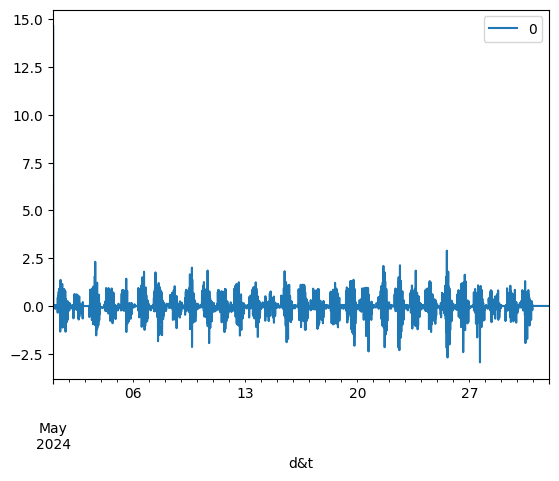

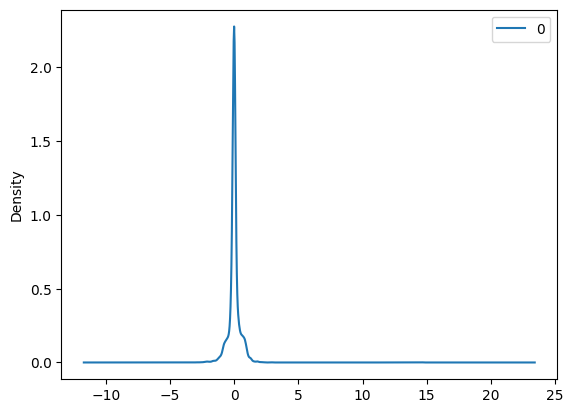

                 0
count  4464.000000
mean      0.003232
std       0.474920
min      -2.943804
25%      -0.094409
50%       0.000000
75%       0.078336
max      14.632653


In [28]:
# fit model
model_arima = ARIMA(test_df, order=(6,1,0))
model_fit = model_arima.fit()

# summary of fit model
print(model_fit.summary())

# line plot of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()

# density plot of residuals
residuals.plot(kind='kde')
plt.show()

# summary stats of residuals
print(residuals.describe())

In [29]:
dynamic_values = list()
dynamic_count = 0
k = 0

while (k <= len(test_dynamic)):
    if dynamic_count <= 72:
        dynamic_values.append(test_dynamic[k:k+1])
        k += 1
    elif dynamic_count <= (72 + 72):
        dynamic_values.append(test_dynamic[k:k+1])
        k += 3
    else:
        dynamic_values.append(test_dynamic[k:k+1])
        k += 6
    dynamic_count += 1

dynamic_values = array(dynamic_values)
dynamic_values = dynamic_values.astype('float32')
dynamic_values = dynamic_values.reshape((dynamic_values.shape[0]*dynamic_values.shape[1], dynamic_values.shape[2]))
scaler_dynamic = MinMaxScaler(feature_range=(0, 1))
test_dynamic = scaler_dynamic.fit_transform(dynamic_values)

In [30]:
# split into train and test sets
train_arima, test_arima = df_lstm_training, df_lstm_testing
history_arima = [x for x in train_arima]
predictions_arima = list()
rmse_per_prediction = []  # List to store RMSE per prediction

check = True
n_forecast = 0
n_steps = 6
percentage = 0

model_arima = ARIMA(history_arima, order=(n_steps,1,0))
model_fit = model_arima.fit()

prediction_count = 0 # To track how many predictions we have made

# walk-forward validation
while check:
	
	# Determine n_output dynamically
	if (prediction_count <= 72):
		n_forecast = 1  # 10 minute predictions
	elif (prediction_count <= (72 + 72)):
		n_forecast = 3  # Every 30 minutes hours
	else:
		n_forecast = 6  # Every 1 hour

	# Forecast n_forecast steps ahead
	output_arima = model_fit.forecast(steps=n_forecast)
	yhat_arima = output_arima[n_forecast-1:n_forecast]  # Get the predicted values

	# Store predictions
	predictions_arima.extend(yhat_arima)

	# Append actual observations to history
	actual_value_sing = test_arima[percentage+n_forecast-1:percentage+n_forecast]  # Get actual singular value
	actual_values = test_arima[percentage:percentage+n_forecast]  # Get actual values for n timesteps
	history_arima.extend(actual_values)

	# Update the model with the new history (without refitting)
	model_fit = model_fit.append(actual_values, refit=False)

	# Compute RMSE for prediction
	singular_rmse = np.sqrt(np.mean((yhat_arima - actual_value_sing) ** 2))
	rmse_per_prediction.append(singular_rmse)

	# Update completion percentage
	percentage += n_forecast  # Move ahead by n_forecast steps
	prediction_count += 1
	completion_rate = (percentage / len(test_arima)) * 100
	
	print(f'Predicted {n_forecast} steps ahead | RMSE={singular_rmse:.6f} | {completion_rate:.0f}% complete')
	
	if (percentage >= len(test_arima)):
		check = False


Predicted 1 steps ahead | RMSE=0.183816 | 0% complete
Predicted 1 steps ahead | RMSE=0.048153 | 0% complete
Predicted 1 steps ahead | RMSE=0.006075 | 0% complete
Predicted 1 steps ahead | RMSE=0.015023 | 0% complete
Predicted 1 steps ahead | RMSE=0.005115 | 0% complete
Predicted 1 steps ahead | RMSE=0.009876 | 0% complete
Predicted 1 steps ahead | RMSE=0.012052 | 0% complete
Predicted 1 steps ahead | RMSE=0.001939 | 0% complete
Predicted 1 steps ahead | RMSE=0.001913 | 0% complete
Predicted 1 steps ahead | RMSE=0.001590 | 0% complete
Predicted 1 steps ahead | RMSE=0.001601 | 0% complete
Predicted 1 steps ahead | RMSE=0.000741 | 0% complete
Predicted 1 steps ahead | RMSE=0.000885 | 0% complete
Predicted 1 steps ahead | RMSE=0.000571 | 0% complete
Predicted 1 steps ahead | RMSE=0.000453 | 0% complete
Predicted 1 steps ahead | RMSE=0.000243 | 0% complete
Predicted 1 steps ahead | RMSE=0.000000 | 0% complete
Predicted 1 steps ahead | RMSE=0.000000 | 0% complete
Predicted 1 steps ahead | RM

d:\Users\ugurhan\Desktop\LSTM Model\.venv\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\Users\ugurhan\Desktop\LSTM Model\.venv\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [31]:
predictions_arima = np.asarray(predictions_arima, dtype="object")

# evaluate predictions hours for each day
predictions_arima = array(predictions_arima)

# Reshape `predictions` before inverse transform
n_samples = predictions_arima.shape
predictions_arima_tf = predictions_arima.reshape(n_samples[0] * 1, 1)

# Create a scaler for the target feature only
target_scaler = MinMaxScaler(feature_range=(0, 1))

# Initialize its internal parameters using the ones from the full scaler
# The scaler must belong to the targeted feature's column
target_scaler.min_ = scaler_dynamic.min_[0].reshape(1,)
target_scaler.scale_ = scaler_dynamic.scale_[0].reshape(1,)
target_scaler.data_min_ = scaler_dynamic.data_min_[0].reshape(1,)
target_scaler.data_max_ = scaler_dynamic.data_max_[0].reshape(1,)
target_scaler.data_range_ = scaler_dynamic.data_range_[0].reshape(1,)

predictions_arima_tf = target_scaler.inverse_transform(predictions_arima_tf)
predictions_arima = predictions_arima_tf.reshape(n_samples[0], 1, 1)

n_samples, n_features = test_dynamic.shape
test_reshaped = scaler_dynamic.inverse_transform(test_dynamic)
    
test = test_reshaped.reshape(n_samples, n_features, 1)

C:\Users\ugurhan\AppData\Local\Temp\ipykernel_25524\1693070273.py:8: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  hourly_dates = pd.date_range(start=start_date, periods=72, freq='10T')  # First 72 points (10 mins)
C:\Users\ugurhan\AppData\Local\Temp\ipykernel_25524\1693070273.py:9: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  six_hour_dates = pd.date_range(start=hourly_dates[-1] + pd.Timedelta(hours=3), periods=72, freq='30T')  # Next 72 points (half-hour)
C:\Users\ugurhan\AppData\Local\Temp\ipykernel_25524\1693070273.py:10: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  daily_dates = pd.date_range(start=six_hour_dates[-1] + pd.Timedelta(days=6), periods=len(predictions_dynamic)-144, freq='H')  # Remaining points (hourly)


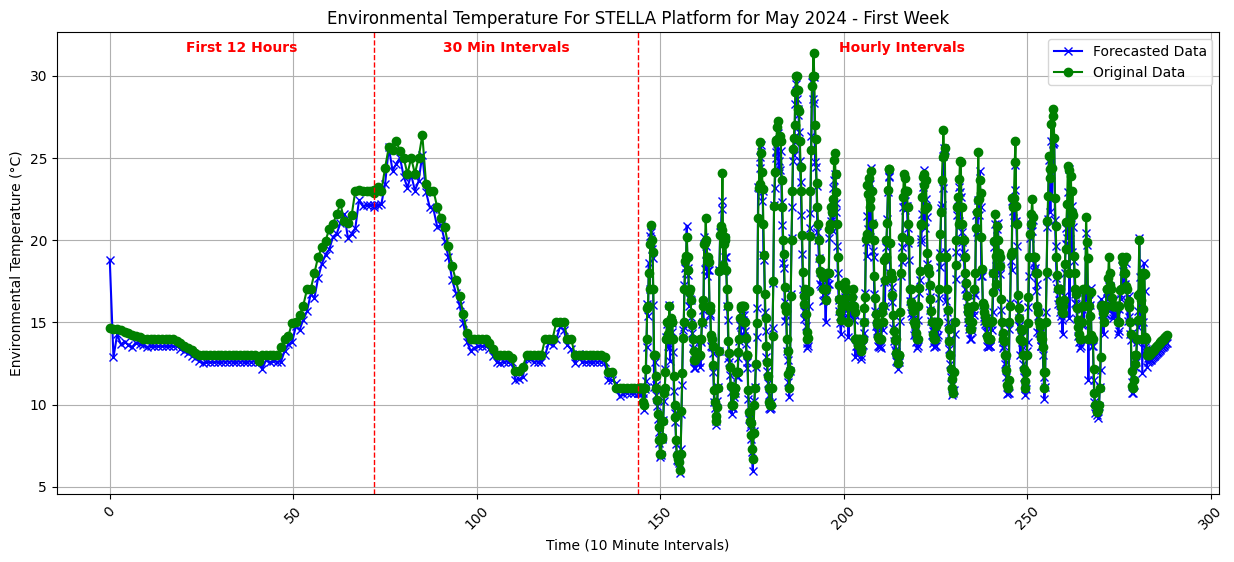

In [32]:
flattened_predictions_arima = predictions_arima.flatten()
flattened_test_arima = test[:,0].flatten()

# Assume `start_date` is the first timestamp of your forecast
start_date = pd.Timestamp("2024-03-01")

# Generate corresponding time index
hourly_dates = pd.date_range(start=start_date, periods=72, freq='10T')  # First 72 points (10 mins)
six_hour_dates = pd.date_range(start=hourly_dates[-1] + pd.Timedelta(hours=3), periods=72, freq='30T')  # Next 72 points (half-hour)
daily_dates = pd.date_range(start=six_hour_dates[-1] + pd.Timedelta(days=6), periods=len(predictions_dynamic)-144, freq='H')  # Remaining points (hourly)

# Combine all time indexes
time_index = hourly_dates.append(six_hour_dates).append(daily_dates)

# Manually create a modified x-axis index for readability
x_ticks = np.concatenate([
    np.linspace(0, 72, len(hourly_dates)), 
    np.linspace(72, 144, len(six_hour_dates)), 
    np.linspace(144, 288, len(daily_dates))  
])

# Plot the forecasted values
plt.figure(figsize=(15, 6))
plt.plot(x_ticks, flattened_predictions_arima, marker='x', linestyle='-', color='b', label="Forecasted Data")
plt.plot(x_ticks, flattened_test_arima, marker='o', linestyle='-', color='g', label="Original Data")

# Formatting the x-axis
plt.xlabel("Time (10 Minute Intervals)")
plt.ylabel("Environmental Temperature (°C)")
plt.title("Environmental Temperature For STELLA Platform for May 2024 - First Week")
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.legend()
plt.grid()

# **Draw vertical lines to separate the intervals**
plt.axvline(x=x_ticks[len(hourly_dates)-1], color='r', linestyle='--', linewidth=1)  # End of hourly interval
plt.axvline(x=x_ticks[len(hourly_dates) + len(six_hour_dates)-1], color='r', linestyle='--', linewidth=1)  # End of 6-hour interval

# **Calculate midpoints for centered text annotations**
mid_hourly = (x_ticks[0] + x_ticks[len(hourly_dates)-1]) / 2
mid_six_hour = (x_ticks[len(hourly_dates)] + x_ticks[len(hourly_dates) + len(six_hour_dates)-1]) / 2
mid_daily = (x_ticks[len(hourly_dates) + len(six_hour_dates)] + x_ticks[-1]) / 2

# **Add text annotations at the center of each interval in bold**
plt.text(mid_hourly, max(flattened_predictions_arima) * 1.05, "First 12 Hours", 
         ha='center', fontsize=10, color='r', fontweight='bold')
plt.text(mid_six_hour, max(flattened_predictions_arima) * 1.05, "30 Min Intervals", 
         ha='center', fontsize=10, color='r', fontweight='bold')
plt.text(mid_daily, max(flattened_predictions_arima) * 1.05, "Hourly Intervals", 
         ha='center', fontsize=10, color='r', fontweight='bold')

# Show the plot
plt.show()

Average RMSE: 0.6698


C:\Users\ugurhan\AppData\Local\Temp\ipykernel_25524\276687015.py:9: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  hourly_dates = pd.date_range(start=start_date, periods=72, freq='10T')  # First 72 points (10 mins)
C:\Users\ugurhan\AppData\Local\Temp\ipykernel_25524\276687015.py:10: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  six_hour_dates = pd.date_range(start=hourly_dates[-1] + pd.Timedelta(hours=3), periods=72, freq='30T')  # Next 72 points (half-hour)
C:\Users\ugurhan\AppData\Local\Temp\ipykernel_25524\276687015.py:11: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  daily_dates = pd.date_range(start=six_hour_dates[-1] + pd.Timedelta(days=6), periods=len(predictions_dynamic)-144, freq='H')  # Remaining points (hourly)


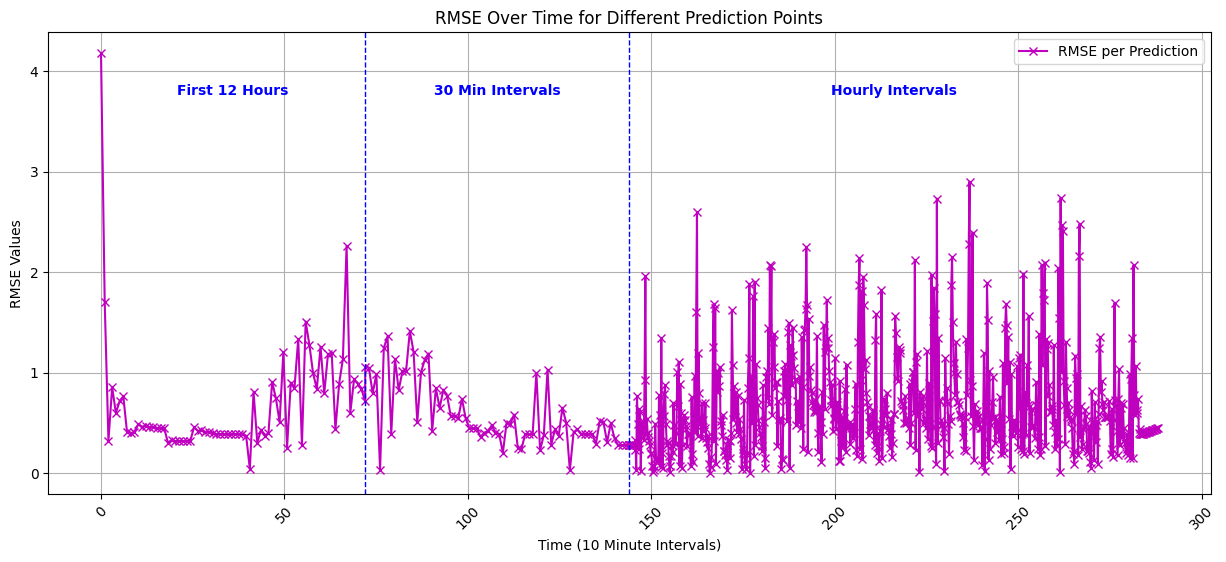

In [33]:
# Compute RMSE for each point
rmse_values = np.sqrt((flattened_predictions_arima - flattened_test_arima) ** 2)

# Compute average RMSE
average_rmse = np.mean(rmse_values)
print(f'Average RMSE: {average_rmse:.4f}')

# Generate custom x-axis spacing
hourly_dates = pd.date_range(start=start_date, periods=72, freq='10T')  # First 72 points (10 mins)
six_hour_dates = pd.date_range(start=hourly_dates[-1] + pd.Timedelta(hours=3), periods=72, freq='30T')  # Next 72 points (half-hour)
daily_dates = pd.date_range(start=six_hour_dates[-1] + pd.Timedelta(days=6), periods=len(predictions_dynamic)-144, freq='H')  # Remaining points (hourly)

# Combine all time indexes
time_index = hourly_dates.append(six_hour_dates).append(daily_dates)

# Manually create a modified x-axis index for readability
x_ticks = np.concatenate([
    np.linspace(0, 72, len(hourly_dates)), 
    np.linspace(72, 144, len(six_hour_dates)), 
    np.linspace(144, 288, len(daily_dates))  
])

# Plot RMSE values
plt.figure(figsize=(15, 6))
plt.plot(x_ticks, rmse_values, marker='x', linestyle='-', color='m', label="RMSE per Prediction")

# Formatting the x-axis
plt.xlabel("Time (10 Minute Intervals)")
plt.ylabel("RMSE Values")
plt.title("RMSE Over Time for Different Prediction Points")
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.legend()
plt.grid()

# Draw vertical dashed lines for intervals
plt.axvline(x=x_ticks[len(hourly_dates)-1], color='b', linestyle='--', linewidth=1)  # End of hourly interval
plt.axvline(x=x_ticks[len(hourly_dates) + len(six_hour_dates)-1], color='b', linestyle='--', linewidth=1)  # End of 6-hour interval

# Calculate midpoints for centered text annotations
mid_hourly = (x_ticks[0] + x_ticks[len(hourly_dates)-1]) / 2
mid_six_hour = (x_ticks[len(hourly_dates)] + x_ticks[len(hourly_dates) + len(six_hour_dates)-1]) / 2
mid_daily = (x_ticks[len(hourly_dates) + len(six_hour_dates)] + x_ticks[-1]) / 2

# Add interval text annotations
plt.text(mid_hourly, max(rmse_values) * 0.90, "First 12 Hours", 
         ha='center', fontsize=10, color='b', fontweight='bold')
plt.text(mid_six_hour, max(rmse_values) * 0.90, "30 Min Intervals", 
         ha='center', fontsize=10, color='b', fontweight='bold')
plt.text(mid_daily, max(rmse_values) * 0.90, "Hourly Intervals", 
         ha='center', fontsize=10, color='b', fontweight='bold')

# Show the RMSE plot
plt.show()

# Comparison of LSTM and ARIMA

In [34]:
dynamic_values = []
dynamic_dates_selected = []  # List to store the selected datetime indices

dynamic_count = 0
k = 0

while (k <= len(test_df) - 1):  # Prevent out-of-bounds error
    # Append both the date and the value
    dynamic_dates_selected.append(test_df.index[k])  # Store the date
    dynamic_values.append(test_df.iloc[k])  # Store the value
    
    # Adjust k based on dynamic_count
    if dynamic_count <= 72:
        k += 1  # Every 10 minutes
    elif dynamic_count <= (72 + 72):
        k += 3  # Every 30 minutes
    else:
        k += 6  # Hourly

    dynamic_count += 1  # Increment count

# Convert to DataFrame with the correct datetime index
dynamic_df = pd.DataFrame(dynamic_values, columns=['Tamb'], index=dynamic_dates_selected)

# Ensure index is properly formatted as datetime
dynamic_df.index = pd.to_datetime(dynamic_df.index)

print(dynamic_df.head())  # Check results

                          Tamb
2024-05-01 00:00:00  14.632653
2024-05-01 00:10:00  14.571429
2024-05-01 00:20:00  14.600000
2024-05-01 00:30:00  14.514286
2024-05-01 00:40:00  14.428571


In [35]:
# Calculating general and individual RMSE values for both models

rmse_LSTM_multiple = []  # List to store RMSE per prediction
rmse_ARIMA_multiple = []  # List to store ARIMA per prediction

# Evaluate forecasts of LSTM
rmse_LSTM = np.sqrt(mean_squared_error(test_reshaped, flattened_predictions))
print('Overall RMSE for LSTM Model: %.3f' % rmse_LSTM)

for i in range(len(test_reshaped)):
    rmse_LSTM_individual = np.sqrt(np.mean((flattened_predictions[i] - test_reshaped[i]) ** 2))
    rmse_LSTM_multiple.append(rmse_LSTM_individual)


# Evaluate forecasts of LSTM
rmse_ARIMA = np.sqrt(mean_squared_error(test_reshaped, predictions_arima_tf))
print('Overall RMSE for ARIMA Model: %.3f' % rmse_ARIMA)

for k in range(len(test_reshaped)):
    rmse_ARIMA_individual = np.sqrt(np.mean((predictions_arima_tf[k] - test_reshaped[k]) ** 2))
    rmse_ARIMA_multiple.append(rmse_ARIMA_individual)

Overall RMSE for LSTM Model: 0.905
Overall RMSE for ARIMA Model: 0.832


C:\Users\ugurhan\AppData\Local\Temp\ipykernel_25524\1154390421.py:4: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  hourly_dates = pd.date_range(start=start_date, periods=72, freq='10T')  # First 72 points (10 mins)
C:\Users\ugurhan\AppData\Local\Temp\ipykernel_25524\1154390421.py:5: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  six_hour_dates = pd.date_range(start=hourly_dates[-1] + pd.Timedelta(hours=3), periods=72, freq='30T')  # Next 96 points (20 mins)
C:\Users\ugurhan\AppData\Local\Temp\ipykernel_25524\1154390421.py:6: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  daily_dates = pd.date_range(start=six_hour_dates[-1] + pd.Timedelta(days=6), periods=len(predictions_dynamic)-144, freq='H')  # Remaining points (hourly)


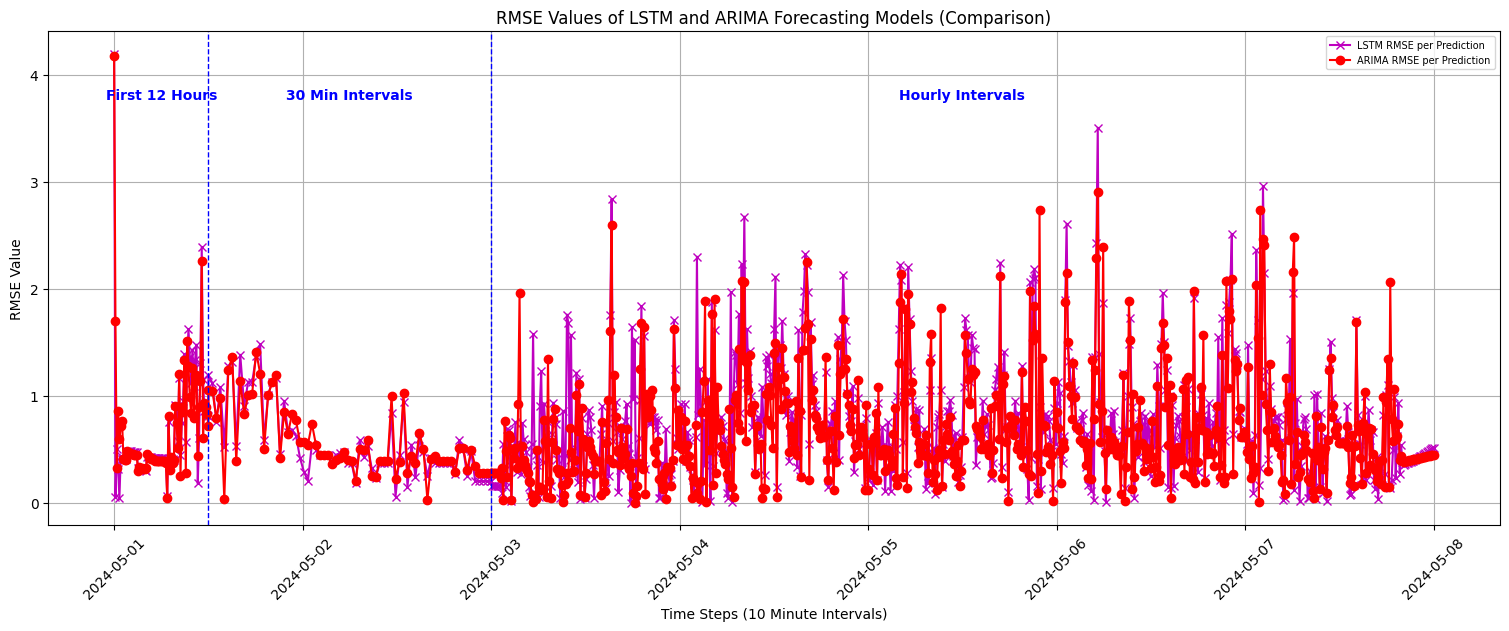

In [36]:
start_date = pd.Timestamp("2024-05-01 00:00:00")

# Generate custom x-axis spacing
hourly_dates = pd.date_range(start=start_date, periods=72, freq='10T')  # First 72 points (10 mins)
six_hour_dates = pd.date_range(start=hourly_dates[-1] + pd.Timedelta(hours=3), periods=72, freq='30T')  # Next 96 points (20 mins)
daily_dates = pd.date_range(start=six_hour_dates[-1] + pd.Timedelta(days=6), periods=len(predictions_dynamic)-144, freq='H')  # Remaining points (hourly)

# Combine all time indexes
time_index = hourly_dates.append(six_hour_dates).append(daily_dates)

start_10 = pd.Timestamp("2024-05-01 00:00:00")
end_10 = pd.Timestamp("2024-05-01 12:00:00")
end_20 = pd.Timestamp("2024-05-03 00:00:00")
end_hour = pd.Timestamp("2024-05-08 00:00:00")

t_10 = pd.date_range(
    start=start_10,
    end=end_10,
    periods=len(hourly_dates)
)

t_20 = pd.date_range(
    start=end_10,
    end=end_20,
    periods=len(six_hour_dates)
)

t_H = pd.date_range(
    start=end_20,
    end=end_hour,
    periods=len(daily_dates)
)

# Manually create a modified x-axis index for readability
x_ticks = np.concatenate([t_10, t_20, t_H])

# Plot RMSE values
plt.figure(figsize=(15, 6))
plt.plot(x_ticks, rmse_LSTM_multiple, marker='x', linestyle='-', color='m', label="LSTM RMSE per Prediction")
plt.plot(x_ticks, rmse_ARIMA_multiple, marker='o', linestyle='-', color='r', label="ARIMA RMSE per Prediction")

# Draw vertical dashed lines for intervals
plt.axvline(x=x_ticks[len(hourly_dates)-1], color='b', linestyle='--', linewidth=1)  # End of hourly interval
plt.axvline(x=x_ticks[len(hourly_dates) + len(six_hour_dates)-1], color='b', linestyle='--', linewidth=1)  # End of 6-hour interval

# Calculate midpoints for centered text annotations
mid_hourly = (mdates.date2num(x_ticks[0]) + mdates.date2num(x_ticks[len(hourly_dates)-1])) / 2
mid_six_hour = (mdates.date2num(x_ticks[len(hourly_dates)]) + mdates.date2num(x_ticks[len(hourly_dates) + len(six_hour_dates)-1])) / 2
mid_daily = (mdates.date2num(x_ticks[len(hourly_dates) + len(six_hour_dates)]) + mdates.date2num(x_ticks[-1])) / 2

# Add interval text annotations
plt.text(mid_hourly, max(rmse_LSTM_multiple) * 0.90, "First 12 Hours", 
         ha='center', fontsize=10, color='b', fontweight='bold')
plt.text(mid_six_hour, max(rmse_LSTM_multiple) * 0.90, "30 Min Intervals", 
         ha='center', fontsize=10, color='b', fontweight='bold')
plt.text(mid_daily, max(rmse_LSTM_multiple) * 0.90, "Hourly Intervals", 
         ha='center', fontsize=10, color='b', fontweight='bold')

# Customize the plot
plt.legend(fontsize=7)
plt.xticks(rotation=45)  # Rotate x-axis labels for clarity
plt.tight_layout()  # Adjust layout to prevent clipping
plt.xlabel('Time Steps (10 Minute Intervals)')
plt.ylabel('RMSE Value')
plt.title('RMSE Values of LSTM and ARIMA Forecasting Models (Comparison)')
plt.grid()
plt.show()

C:\Users\ugurhan\AppData\Local\Temp\ipykernel_25524\1268728516.py:7: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  hourly_dates = pd.date_range(start=start_date, periods=72, freq='10T')  # First 72 points (10 mins)
C:\Users\ugurhan\AppData\Local\Temp\ipykernel_25524\1268728516.py:8: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  six_hour_dates = pd.date_range(start=hourly_dates[-1] + pd.Timedelta(hours=3), periods=72, freq='30T')  # Next 96 points (half-hour)
C:\Users\ugurhan\AppData\Local\Temp\ipykernel_25524\1268728516.py:9: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  daily_dates = pd.date_range(start=six_hour_dates[-1] + pd.Timedelta(days=6), periods=len(predictions_dynamic)-144, freq='H')  # Remaining points (hourly)


RMSE comparison for the first 72 forecast points (12 hours):
RMSE Comparison (LSTM: 51 times, ARIMA: 22 times)


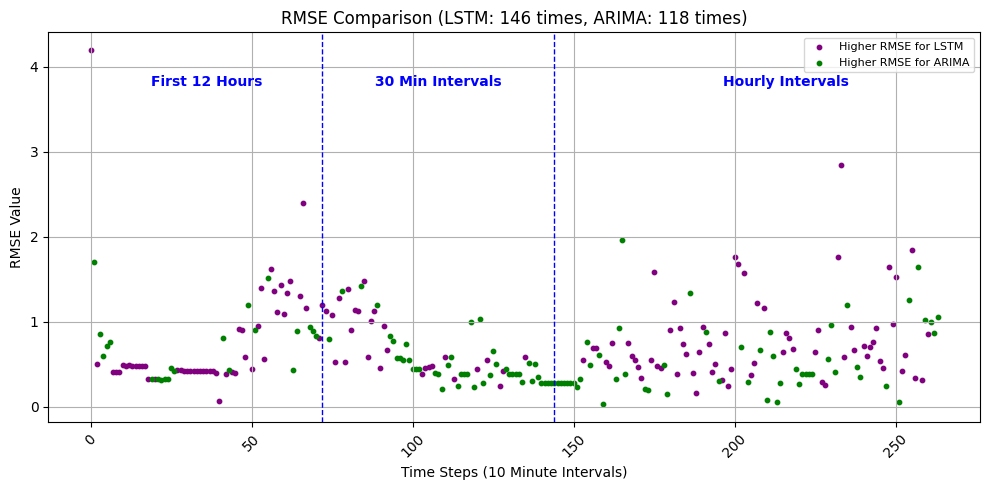

In [37]:
# Comparing individual RMSE values to see how often does one model surpass the other

# Time steps
time_steps = np.arange(len(rmse_LSTM_multiple))

# Generate custom x-axis spacing
hourly_dates = pd.date_range(start=start_date, periods=72, freq='10T')  # First 72 points (10 mins)
six_hour_dates = pd.date_range(start=hourly_dates[-1] + pd.Timedelta(hours=3), periods=72, freq='30T')  # Next 96 points (half-hour)
daily_dates = pd.date_range(start=six_hour_dates[-1] + pd.Timedelta(days=6), periods=len(predictions_dynamic)-144, freq='H')  # Remaining points (hourly)

# Combine all time indexes
time_index = hourly_dates.append(six_hour_dates).append(daily_dates)

# Manually create a modified x-axis index for readability
x_ticks = np.concatenate([
    np.linspace(0, 72, len(hourly_dates)), 
    np.linspace(72, 144, len(six_hour_dates)), 
    np.linspace(144, 288, len(daily_dates))  
])

# Lists to store max values and their respective indexes
LSTM_x, LSTM_y = [], []
ARIMA_x, ARIMA_y = [], []

# Counters for which model has higher RMSE more frequently
LSTM_count, ARIMA_count = 0, 0

# Compare RMSE values at each index
for i in range(264):
    if rmse_LSTM_multiple[i] > rmse_ARIMA_multiple[i]:  
        LSTM_x.append(time_steps[i])
        LSTM_y.append(rmse_LSTM_multiple[i])
        LSTM_count += 1
    else:  
        ARIMA_x.append(time_steps[i])
        ARIMA_y.append(rmse_ARIMA_multiple[i])
        ARIMA_count += 1
    
    if (i == 72):
        print("RMSE comparison for the first 72 forecast points (12 hours):")
        print(f'RMSE Comparison (LSTM: {LSTM_count} times, ARIMA: {ARIMA_count} times)')

# Creating scatter plots only for max values
plt.figure(figsize=(10, 5))
plt.scatter(LSTM_x, LSTM_y, color='purple', label='Higher RMSE for LSTM', s=10)
plt.scatter(ARIMA_x, ARIMA_y, color='green', label='Higher RMSE for ARIMA', s=10)

# Customize the plot
plt.xlabel('Time Steps (10 Minute Intervals)')
plt.ylabel('RMSE Value')
plt.title(f'RMSE Comparison (LSTM: {LSTM_count} times, ARIMA: {ARIMA_count} times)')
plt.legend(fontsize=8)
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

# Draw vertical dashed lines for intervals
plt.axvline(x=x_ticks[len(hourly_dates)-1], color='b', linestyle='--', linewidth=1)  # End of hourly interval
plt.axvline(x=x_ticks[len(hourly_dates) + len(six_hour_dates)-1], color='b', linestyle='--', linewidth=1)  # End of 6-hour interval

# Calculate midpoints for centered text annotations
mid_hourly = (x_ticks[0] + x_ticks[len(hourly_dates)-1]) / 2
mid_six_hour = (x_ticks[len(hourly_dates)] + x_ticks[len(hourly_dates) + len(six_hour_dates)-1]) / 2
mid_daily = (x_ticks[len(hourly_dates) + len(six_hour_dates)] + x_ticks[-1]) / 2

# Add interval text annotations
plt.text(mid_hourly, max(rmse_LSTM_multiple) * 0.90, "First 12 Hours", 
         ha='center', fontsize=10, color='b', fontweight='bold')
plt.text(mid_six_hour, max(rmse_LSTM_multiple) * 0.90, "30 Min Intervals", 
         ha='center', fontsize=10, color='b', fontweight='bold')
plt.text(mid_daily, max(rmse_LSTM_multiple) * 0.90, "Hourly Intervals", 
         ha='center', fontsize=10, color='b', fontweight='bold')

plt.show()

# LSTM Testing Without Dynamic Intervals

## Necessary Functions (Static Forecasting)

In [38]:
# convert history into inputs and outputs
def to_supervised(train, n_input, n_out):
	# flatten data
	data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
	X, y = list(), list()
	in_start = 0
	# step over the entire history one time step at a time
	for _ in range(len(data)):
		# define the end of the input sequence
		in_end = in_start + n_input
		out_end = in_end + n_out
		# ensure we have enough data for this instance
		if out_end <= len(data):
			X.append(data[in_start:in_end, :])
			y.append(data[in_end:out_end, 0]) # Whichever feature needs to be predicted
		# move along one time step
		in_start += 1
	return array(X), array(y)

In [39]:
def forecast(model, history, n_input):
	# flatten data
	data = array(history)
	# data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
	# retrieve last observations for input data
	input_x = data[-n_input:, :]

	# reshape into [1, n_input, n]
	input_x = input_x.reshape((1, input_x.shape[0], input_x.shape[1]))
	# forecast the next week
	yhat = model.predict(input_x, verbose=0)

	# we only want the vector forecast
	yhat = yhat[0]
	return yhat

In [40]:
def reframe_datasets(training, testing, n_input):

	# restructure into windows of hourly data
	train = array(np.split(training, len(training)/n_input))
	test = array(np.split(testing, len(testing)/n_input))

	return train, test

In [41]:
# train the model
def build_model(train, n_input, n_output):
	# prepare data
	train_x, train_y = to_supervised(train, n_input, n_output)

	# define parameters
	verbose, epochs, batch_size = 2, 150, 288
	n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
	# reshape output into [samples, timesteps, features]
	train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
	# define model
	model = Sequential()
	model.add(LSTM(256, activation='relu', input_shape=(n_timesteps, n_features)))
	model.add(RepeatVector(n_outputs))
	model.add(LSTM(256, activation='relu', return_sequences=True))
	model.add(TimeDistributed(Dense(1)))
	model.compile(loss='mse', optimizer='adam')
	# fit network
	model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
	return model

In [42]:
# Evaluate forecasts against expected values
def evaluate_forecasts(actual, predicted):
	scores = list()

	"""
	# Debugging
	print(np.shape(actual))
	print("")
	print(np.shape(predicted))
	print("")
	print(np.shape(actual[:, 0]))
	print("")
	print(np.shape(predicted[:, 0]))
	print("")
	print(actual.shape[1])
	"""

	# calculate an RMSE score for each day
	for i in range(actual.shape[1]):
		# calculate mse
		mse = mean_squared_error(actual[:, i], predicted[:-1, i])
		# calculate rmse
		rmse = np.sqrt(mse)
		# store
		scores.append(rmse)
	# calculate overall RMSE
	s = 0
	for row in range(actual.shape[0]):
		for col in range(actual.shape[1]):
			s += (actual[row, col] - predicted[row, col])**2
	score = np.sqrt(s / (actual.shape[0] * actual.shape[1]))
	return score, scores

In [ ]:
# summarize scores
def summarize_scores(name, score, scores):
	s_scores = ', '.join(['%.1f' % s for s in scores])
	print('%s: [%.3f] %s' % (name, score, s_scores))

In [ ]:
# evaluate a single model
def evaluate_model(model, train, test, n_input, scaler, n_output):

	# history is a list of daily data
	history = [x for x in train]

	history = np.array(history)

	history = history.reshape((history.shape[0]*history.shape[1], history.shape[2]))

	# Reshape `test` before inverse transform
	n_samples, n_timesteps, n_features = test.shape
	test_reshaped = test.reshape(n_samples * n_timesteps, n_features)

	# walk-forward validation over each day
	predictions = list()

	i = 0

	while (i <= len(test_reshaped)):

		# predict the day
		yhat_sequence = forecast(model, history, n_input)

		# store the predictions
		predictions.append(yhat_sequence)

		# get real observation and add to history for predicting the next day
		history = np.append(history, test_reshaped[i:i+len(yhat_sequence),:], axis=0)

		# Calculate completion percentage
		completion_rate = (i + 1) / len(test_reshaped) * 100

		# Print progress on the same line
		print(f'\r{completion_rate:.0f}% complete', end='', flush=True)

		i += n_output

	# evaluate predictions hours for each day
	predictions = array(predictions)

	# Reshape `predictions` before inverse transform
	n_samples, n_timesteps, n_features = predictions.shape
	predictions_reshaped = predictions.reshape(n_samples * n_timesteps, n_features)
	
    # Create a scaler for the target feature only
	target_scaler = MinMaxScaler(feature_range=(0, 1))
	
    # Initialize its internal parameters using the ones from the full scaler
	# The scaler must belong to the targeted feature's column
	target_scaler.min_ = scaler.min_[0].reshape(1,) # Change 0 to desired feature's index
	target_scaler.scale_ = scaler.scale_[0].reshape(1,) # Change 0 to desired feature's index
	target_scaler.data_min_ = scaler.data_min_[0].reshape(1,) # Change 0 to desired feature's index
	target_scaler.data_max_ = scaler.data_max_[0].reshape(1,) # Change 0 to desired feature's index
	target_scaler.data_range_ = scaler.data_range_[0].reshape(1,) # Change 0 to desired feature's index

	predictions_reshaped = target_scaler.inverse_transform(predictions_reshaped)
	predictions = predictions_reshaped.reshape(n_samples, n_timesteps, n_features)

	n_samples, n_timesteps, n_features = test.shape
	test_reshaped = scaler.inverse_transform(test_reshaped)
		
	test = test_reshaped.reshape(n_samples, n_timesteps, n_features)

	return predictions, test

## Forecasting

In [43]:
df_resampled_pv = df_resampled['Tamb']

In [44]:
# Training data
train_df = df_resampled_pv[(df_resampled_pv.index >= '2024-09-01') & (df_resampled_pv.index < '2025-02-01')]
train_df = train_df.to_frame()

# Testing data
test_df = df_resampled_pv[(df_resampled_pv.index >= '2025-02-01')]
test_df = test_df.to_frame()

In [45]:
print(np.shape(train_df))
print(np.shape(test_df))

(22032, 1)
(1440, 1)


In [46]:
# Preparing dataset for LSTM training with dynamic time intervals

df_lstm_training = train_df.values
df_lstm_training = df_lstm_training.astype('float32')

df_lstm_testing = test_df.values
df_lstm_testing = df_lstm_testing.astype('float32')

# Normalize the dataset
# Normalizing the dataset is important for problems like the exploding gradient problem

scaler = MinMaxScaler(feature_range=(0, 1))
df_lstm_training = scaler.fit_transform(df_lstm_training)

scaler = MinMaxScaler(feature_range=(0, 1))
df_lstm_testing = scaler.fit_transform(df_lstm_testing)

n_input = 6
n_output = 6
train, test = reframe_datasets(df_lstm_training, df_lstm_testing, n_input)

In [47]:
model = build_model(train, n_input, n_output)

Epoch 1/150


d:\Users\ugurhan\Desktop\LSTM Model\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


77/77 - 9s - 120ms/step - loss: 0.0309
Epoch 2/150
77/77 - 6s - 72ms/step - loss: 9.3410e-04
Epoch 3/150
77/77 - 6s - 72ms/step - loss: 6.8933e-04
Epoch 4/150
77/77 - 6s - 73ms/step - loss: 6.4828e-04
Epoch 5/150
77/77 - 6s - 74ms/step - loss: 6.2000e-04
Epoch 6/150
77/77 - 6s - 75ms/step - loss: 6.0186e-04
Epoch 7/150
77/77 - 6s - 73ms/step - loss: 5.5391e-04
Epoch 8/150
77/77 - 6s - 73ms/step - loss: 5.1320e-04
Epoch 9/150
77/77 - 6s - 74ms/step - loss: 5.0200e-04
Epoch 10/150
77/77 - 6s - 75ms/step - loss: 4.6539e-04
Epoch 11/150
77/77 - 6s - 76ms/step - loss: 4.1919e-04
Epoch 12/150
77/77 - 6s - 79ms/step - loss: 4.1206e-04
Epoch 13/150
77/77 - 6s - 76ms/step - loss: 3.9868e-04
Epoch 14/150
77/77 - 6s - 74ms/step - loss: 3.9156e-04
Epoch 15/150
77/77 - 6s - 74ms/step - loss: 3.6741e-04
Epoch 16/150
77/77 - 6s - 74ms/step - loss: 3.7409e-04
Epoch 17/150
77/77 - 6s - 74ms/step - loss: 3.5596e-04
Epoch 18/150
77/77 - 6s - 73ms/step - loss: 3.5662e-04
Epoch 19/150
77/77 - 6s - 72ms/ste

In [50]:
# Evaluate model and get scores
predictions, test = evaluate_model(model, train, test, n_input, scaler, n_output)

100% complete

In [51]:
flattened_predictions = predictions.flatten()

# evaluate forecasts
rmse = np.sqrt(mean_squared_error(test_df['Tamb'].values, flattened_predictions[:-6]))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.655


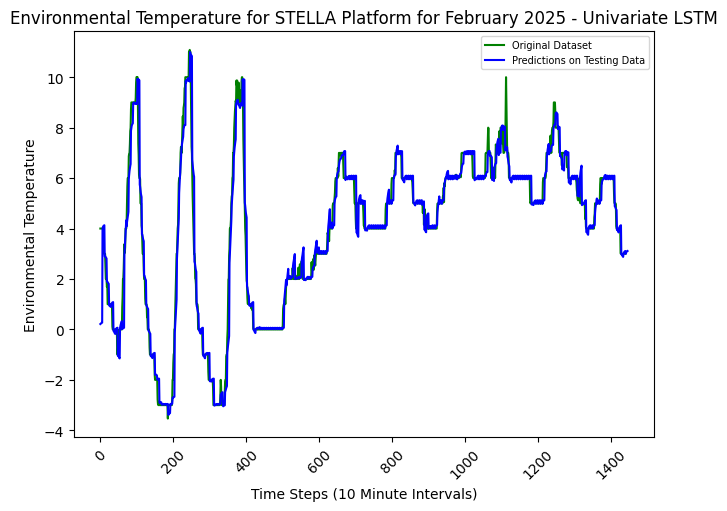

In [52]:
flattened_predictions = predictions.flatten()

# Plot baseline and predictions

plt.plot(test_df['Tamb'].values, 'g', label='Original Dataset')
plt.plot(flattened_predictions, 'b', label='Predictions on Testing Data')
plt.legend(fontsize=7)

plt.xticks(rotation=45)  # Rotate x-axis labels for clarity
plt.tight_layout()  # Adjust layout to prevent clipping
plt.xlabel('Time Steps (10 Minute Intervals)')
plt.ylabel('Environmental Temperature')
plt.title('Environmental Temperature for STELLA Platform for February 2025 - Univariate LSTM')
plt.show()

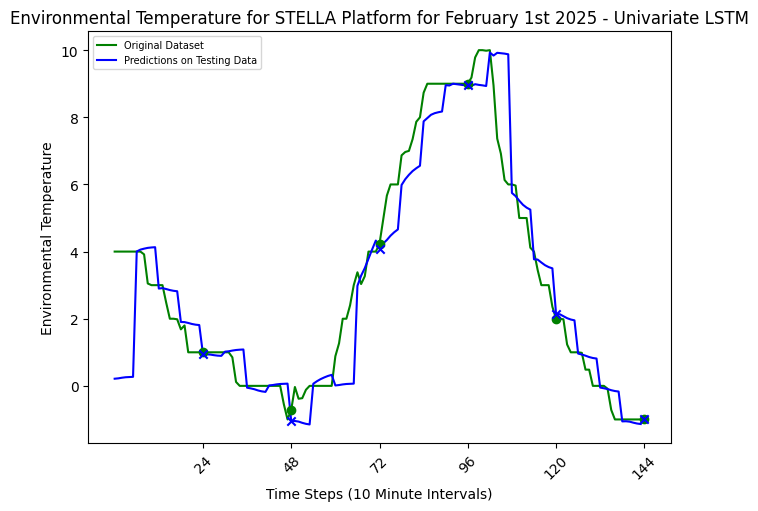

In [53]:
# Plot baseline and predictions for the first 168 timesteps
plt.plot(test_df['Tamb'].values[:144], 'g', label='Original Dataset')  # Slice the first 168 timesteps
plt.plot(flattened_predictions[:144], 'b', label='Predictions on Testing Data')  # Slice the first 168 timesteps

# Define the tick positions and labels
tick_positions = [24, 48, 72, 96, 120, 144]
tick_labels = [str(tick) for tick in tick_positions]  # Convert to strings for labeling

# Get the y-values corresponding to the x-tick positions
original_y_values = test_df['Tamb'].values[tick_positions]
predicted_y_values = flattened_predictions[tick_positions]

# Add pins (markers) at xtick locations
plt.scatter(tick_positions, original_y_values, color='g', marker='o', zorder=3)
plt.scatter(tick_positions, predicted_y_values, color='blue', marker='x', zorder=3)

# Customize the plot
plt.legend(fontsize=7)
plt.xticks(tick_positions, tick_labels, rotation=45)  # Set tick positions and labels
plt.tight_layout()  # Adjust layout to prevent clipping
plt.xlabel('Time Steps (10 Minute Intervals)')
plt.ylabel('Environmental Temperature')
plt.title('Environmental Temperature for STELLA Platform for February 1st 2025 - Univariate LSTM')
plt.show()

# Multivariate LSTM

## Necessary Functions

In [54]:
# convert history into inputs and outputs
def to_supervised(train, n_input, n_out):
	# flatten data
	data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
	X, y = list(), list()
	in_start = 0
	# step over the entire history one time step at a time
	for _ in range(len(data)):
		# define the end of the input sequence
		in_end = in_start + n_input
		out_end = in_end + n_out
		# ensure we have enough data for this instance
		if out_end <= len(data):
			X.append(data[in_start:in_end, :])
			y.append(data[in_end:out_end, 0]) # Whichever feature needs to be predicted
		# move along one time step
		in_start += 1
	return array(X), array(y)

In [55]:
def forecast(model, history, n_input):
	# flatten data
	data = array(history)
	# data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
	# retrieve last observations for input data
	input_x = data[-n_input:, :]

	# reshape into [1, n_input, n]
	input_x = input_x.reshape((1, input_x.shape[0], input_x.shape[1]))
	# forecast the next week
	yhat = model.predict(input_x, verbose=0)

	# we only want the vector forecast
	yhat = yhat[0]
	return yhat

In [56]:
def reframe_datasets(training, testing, n_input):

	# restructure into windows of hourly data
	train = array(np.split(training, len(training)/n_input))
	test = array(np.split(testing, len(testing)/n_input))

	return train, test

In [57]:
# train the model
def build_model(train, n_input, n_output):
	# prepare data
	train_x, train_y = to_supervised(train, n_input, n_output)

	# define parameters
	verbose, epochs, batch_size = 2, 150, 288
	n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
	# reshape output into [samples, timesteps, features]
	train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
	# define model
	model = Sequential()
	model.add(LSTM(256, activation='relu', input_shape=(n_timesteps, n_features)))
	model.add(RepeatVector(n_outputs))
	model.add(LSTM(256, activation='relu', return_sequences=True))
	model.add(TimeDistributed(Dense(1)))
	model.compile(loss='mse', optimizer='adam')
	# fit network
	model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
	return model

In [58]:
# Evaluate forecasts against expected values
def evaluate_forecasts(actual, predicted):
	scores = list()

	"""
	# Debugging
	print(np.shape(actual))
	print("")
	print(np.shape(predicted))
	print("")
	print(np.shape(actual[:, 0]))
	print("")
	print(np.shape(predicted[:, 0]))
	print("")
	print(actual.shape[1])
	"""

	# calculate an RMSE score for each day
	for i in range(actual.shape[1]):
		# calculate mse
		mse = mean_squared_error(actual[:, i], predicted[:-1, i])
		# calculate rmse
		rmse = np.sqrt(mse)
		# store
		scores.append(rmse)
	# calculate overall RMSE
	s = 0
	for row in range(actual.shape[0]):
		for col in range(actual.shape[1]):
			s += (actual[row, col] - predicted[row, col])**2
	score = np.sqrt(s / (actual.shape[0] * actual.shape[1]))
	return score, scores

In [ ]:
# summarize scores
def summarize_scores(name, score, scores):
	s_scores = ', '.join(['%.1f' % s for s in scores])
	print('%s: [%.3f] %s' % (name, score, s_scores))

In [ ]:
# evaluate a single model
def evaluate_model(model, train, test, n_input, scaler, n_output):

	# history is a list of daily data
	history = [x for x in train]

	history = np.array(history)

	history = history.reshape((history.shape[0]*history.shape[1], history.shape[2]))

	# Reshape `test` before inverse transform
	n_samples, n_timesteps, n_features = test.shape
	test_reshaped = test.reshape(n_samples * n_timesteps, n_features)

	# walk-forward validation over each day
	predictions = list()

	i = 0

	while (i <= len(test_reshaped)):

		# predict the day
		yhat_sequence = forecast(model, history, n_input)

		# store the predictions
		predictions.append(yhat_sequence)

		# get real observation and add to history for predicting the next day
		history = np.append(history, test_reshaped[i:i+len(yhat_sequence),:], axis=0)

		# Calculate completion percentage
		completion_rate = (i + 1) / len(test_reshaped) * 100

		# Print progress on the same line
		print(f'\r{completion_rate:.0f}% complete', end='', flush=True)

		i += n_output

	# evaluate predictions hours for each day
	predictions = array(predictions)

	# Reshape `predictions` before inverse transform
	n_samples, n_timesteps, n_features = predictions.shape
	predictions_reshaped = predictions.reshape(n_samples * n_timesteps, n_features)
	
    # Create a scaler for the target feature only
	target_scaler = MinMaxScaler(feature_range=(0, 1))
	
    # Initialize its internal parameters using the ones from the full scaler
	# The scaler must belong to the targeted feature's column
	target_scaler.min_ = scaler.min_[0].reshape(1,) # Change 0 to desired feature's index
	target_scaler.scale_ = scaler.scale_[0].reshape(1,) # Change 0 to desired feature's index
	target_scaler.data_min_ = scaler.data_min_[0].reshape(1,) # Change 0 to desired feature's index
	target_scaler.data_max_ = scaler.data_max_[0].reshape(1,) # Change 0 to desired feature's index
	target_scaler.data_range_ = scaler.data_range_[0].reshape(1,) # Change 0 to desired feature's index

	predictions_reshaped = target_scaler.inverse_transform(predictions_reshaped)
	predictions = predictions_reshaped.reshape(n_samples, n_timesteps, n_features)

	n_samples, n_timesteps, n_features = test.shape
	test_reshaped = scaler.inverse_transform(test_reshaped)
		
	test = test_reshaped.reshape(n_samples, n_timesteps, n_features)

	return predictions, test

## Forecasting

In [59]:
df_resampled_pv_g = df_resampled[['Tamb','g']]

In [60]:
# Training data
train_df = df_resampled_pv_g[(df_resampled_pv_g.index >= '2024-09-01') & (df_resampled_pv_g.index < '2025-02-01')]

# Testing data
test_df = df_resampled_pv_g[(df_resampled_pv_g.index >= '2025-02-01')]

In [61]:
print(np.shape(train_df))
print(np.shape(test_df))

(22032, 2)
(1440, 2)


In [62]:
# Preparing dataset for LSTM training with dynamic time intervals

df_lstm_training = train_df.values
df_lstm_training = df_lstm_training.astype('float32')

df_lstm_testing = test_df.values
df_lstm_testing = df_lstm_testing.astype('float32')

# Normalize the dataset
# Normalizing the dataset is important for problems like the exploding gradient problem

scaler = MinMaxScaler(feature_range=(0, 1))
df_lstm_training = scaler.fit_transform(df_lstm_training)

scaler = MinMaxScaler(feature_range=(0, 1))
df_lstm_testing = scaler.fit_transform(df_lstm_testing)

n_input = 6
n_output = 6
train, test = reframe_datasets(df_lstm_training, df_lstm_testing, n_input)

In [63]:
model = build_model(train, n_input, n_output)

Epoch 1/150


d:\Users\ugurhan\Desktop\LSTM Model\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


77/77 - 10s - 124ms/step - loss: 0.0280
Epoch 2/150
77/77 - 6s - 76ms/step - loss: 6.7160e-04
Epoch 3/150
77/77 - 6s - 74ms/step - loss: 5.0789e-04
Epoch 4/150
77/77 - 6s - 77ms/step - loss: 4.4401e-04
Epoch 5/150
77/77 - 6s - 74ms/step - loss: 4.0890e-04
Epoch 6/150
77/77 - 6s - 74ms/step - loss: 3.9868e-04
Epoch 7/150
77/77 - 6s - 74ms/step - loss: 3.8677e-04
Epoch 8/150
77/77 - 6s - 75ms/step - loss: 3.7558e-04
Epoch 9/150
77/77 - 6s - 73ms/step - loss: 3.6366e-04
Epoch 10/150
77/77 - 6s - 73ms/step - loss: 3.5568e-04
Epoch 11/150
77/77 - 6s - 72ms/step - loss: 3.4382e-04
Epoch 12/150
77/77 - 6s - 73ms/step - loss: 3.2156e-04
Epoch 13/150
77/77 - 6s - 80ms/step - loss: 3.1310e-04
Epoch 14/150
77/77 - 6s - 78ms/step - loss: 3.0813e-04
Epoch 15/150
77/77 - 6s - 72ms/step - loss: 3.0416e-04
Epoch 16/150
77/77 - 6s - 73ms/step - loss: 2.9995e-04
Epoch 17/150
77/77 - 6s - 73ms/step - loss: 2.9535e-04
Epoch 18/150
77/77 - 6s - 73ms/step - loss: 2.9143e-04
Epoch 19/150
77/77 - 6s - 74ms/st

In [66]:
# Evaluate model and get scores
predictions, test = evaluate_model(model, train, test, n_input, scaler, n_output)

100% complete

In [67]:
flattened_predictions = predictions.flatten()

# evaluate forecasts
rmse = np.sqrt(mean_squared_error(test_df['Tamb'].values, flattened_predictions[:-6]))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.660


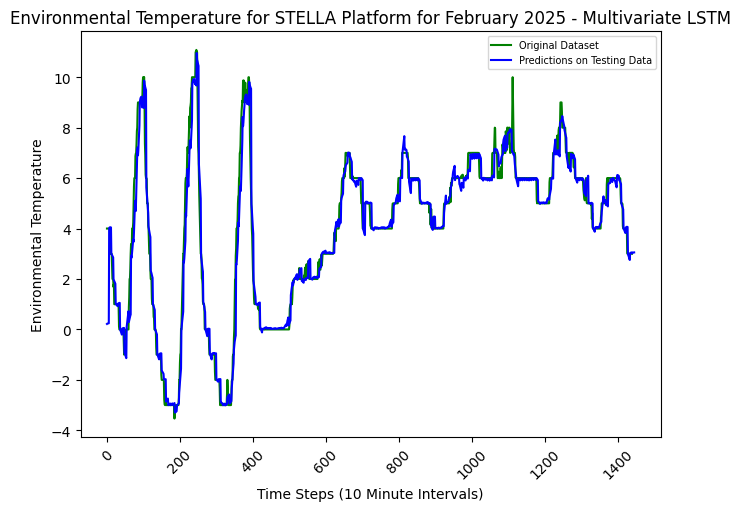

In [68]:
flattened_predictions = predictions.flatten()

# Plot baseline and predictions

plt.plot(test_df['Tamb'].values, 'g', label='Original Dataset')
plt.plot(flattened_predictions, 'b', label='Predictions on Testing Data')
plt.legend(fontsize=7)

plt.xticks(rotation=45)  # Rotate x-axis labels for clarity
plt.tight_layout()  # Adjust layout to prevent clipping
plt.xlabel('Time Steps (10 Minute Intervals)')
plt.ylabel('Environmental Temperature')
plt.title('Environmental Temperature for STELLA Platform for February 2025 - Multivariate LSTM')
plt.show()

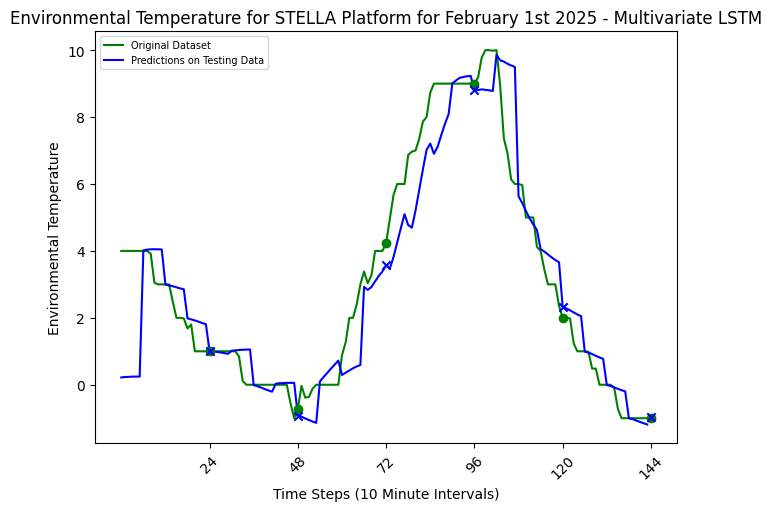

In [69]:
# Plot baseline and predictions for the first 168 timesteps
plt.plot(test_df['Tamb'].values[:144], 'g', label='Original Dataset')  # Slice the first 168 timesteps
plt.plot(flattened_predictions[:144], 'b', label='Predictions on Testing Data')  # Slice the first 168 timesteps

# Define the tick positions and labels
tick_positions = [24, 48, 72, 96, 120, 144]
tick_labels = [str(tick) for tick in tick_positions]  # Convert to strings for labeling

# Get the y-values corresponding to the x-tick positions
original_y_values = test_df['Tamb'].values[tick_positions]
predicted_y_values = flattened_predictions[tick_positions]

# Add pins (markers) at xtick locations
plt.scatter(tick_positions, original_y_values, color='g', marker='o', zorder=3)
plt.scatter(tick_positions, predicted_y_values, color='blue', marker='x', zorder=3)

# Customize the plot
plt.legend(fontsize=7)
plt.xticks(tick_positions, tick_labels, rotation=45)  # Set tick positions and labels
plt.tight_layout()  # Adjust layout to prevent clipping
plt.xlabel('Time Steps (10 Minute Intervals)')
plt.ylabel('Environmental Temperature')
plt.title('Environmental Temperature for STELLA Platform for February 1st 2025 - Multivariate LSTM')
plt.show()

# Multivariate ARIMA

In [70]:
df_resampled_pv_g = df_resampled[['Tamb','g']]

In [71]:
# Training data
train_df = df_resampled_pv_g[(df_resampled_pv_g.index >= '2024-09-01') & (df_resampled_pv_g.index < '2025-02-01')]

# Testing data
test_df = df_resampled_pv_g[(df_resampled_pv_g.index >= '2025-02-01')]

In [72]:
print(np.shape(train_df))
print(np.shape(test_df))

(22032, 2)
(1440, 2)


In [73]:
# Preparing dataset for LSTM training with dynamic time intervals

df_lstm_training = train_df.values
df_lstm_training = df_lstm_training.astype('float32')

df_lstm_testing = test_df.values
df_lstm_testing = df_lstm_testing.astype('float32')

# Normalize the dataset
# Normalizing the dataset is important for problems like the exploding gradient problem

scaler = MinMaxScaler(feature_range=(0, 1))
df_lstm_training = scaler.fit_transform(df_lstm_training)

scaler = MinMaxScaler(feature_range=(0, 1))
df_lstm_testing = scaler.fit_transform(df_lstm_testing)

In [74]:
model_arima = pm.auto_arima(df_lstm_training[:,0], 
                        m=12, seasonal=True,
                      start_p=24, max_p=24, start_q=0, max_q=1, test='adf',error_action='ignore',  
                           suppress_warnings=True,
                      stepwise=True, trace=True)

Performing stepwise search to minimize aic
 ARIMA(11,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=175.58 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=-18025.201, Time=1.43 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=inf, Time=14.09 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=-71945.034, Time=20.47 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=27273.041, Time=0.62 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=-47542.876, Time=3.55 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : AIC=inf, Time=43.34 sec
 ARIMA(0,0,1)(0,0,2)[12] intercept   : AIC=-86712.841, Time=96.93 sec
 ARIMA(0,0,1)(1,0,2)[12] intercept   : AIC=inf, Time=119.71 sec
 ARIMA(0,0,0)(0,0,2)[12] intercept   : AIC=-59684.490, Time=48.30 sec
 ARIMA(1,0,1)(0,0,2)[12] intercept   : AIC=-156172.362, Time=90.57 sec
 ARIMA(1,0,1)(0,0,1)[12] intercept   : AIC=-156172.144, Time=30.66 sec
 ARIMA(1,0,1)(1,0,2)[12] intercept   : AIC=inf, Time=159.29 sec
 ARIMA(1,0,1)(1,0,1)[12] intercept   : AIC=inf, Time=57.89 sec
 ARIMA(1,0,0)(0,0

In [75]:
model_arima.fit(df_lstm_training[:,0])

ARIMA(order=(2, 0, 1), scoring_args={}, seasonal_order=(0, 0, 0, 12),
      suppress_warnings=True)

In [76]:
# split into train and test sets
train_arima, test_arima = df_lstm_training, df_lstm_testing
history_arima = [x for x in train_arima]
predictions_arima = list()
rmse_per_prediction = []  # List to store RMSE per prediction

check = True
n_forecast = 6
n_steps = 6
percentage = 0

# walk-forward validation
while check:
	
	# Forecast n_forecast steps ahead
	output_arima = model_arima.predict(n_periods=n_forecast, return_conf_int=True)
	yhat_arima = output_arima[:n_forecast]  # Get the predicted values

	# Store predictions
	predictions_arima.extend(yhat_arima)

	# Append actual observations to history
	actual_values = test_arima[percentage:percentage+n_forecast]  # Get actual values for next n timesteps
	history_arima.extend(actual_values)

	# Update the model with the new history (without refitting)
	model_arima = model_arima.update(actual_values[:,1])

	# Compute RMSE for these 7 predictions
	multiple_rmse = np.sqrt(np.mean((yhat_arima[0] - actual_values[:,1]) ** 2))
	rmse_per_prediction.append(multiple_rmse)

	# Update completion percentage
	percentage += n_forecast  # Move ahead by n_forecast steps
	completion_rate = (percentage / len(test_arima)) * 100
	
	print(f'Predicted {n_forecast} steps ahead | RMSE={multiple_rmse:.6f} | {completion_rate:.0f}% complete')
	
	if (percentage >= len(test_arima)):
		check = False


Predicted 6 steps ahead | RMSE=0.252397 | 0% complete
Predicted 6 steps ahead | RMSE=0.003312 | 1% complete
Predicted 6 steps ahead | RMSE=0.004598 | 1% complete
Predicted 6 steps ahead | RMSE=0.003005 | 2% complete
Predicted 6 steps ahead | RMSE=0.003163 | 2% complete
Predicted 6 steps ahead | RMSE=0.002800 | 2% complete
Predicted 6 steps ahead | RMSE=0.001905 | 3% complete
Predicted 6 steps ahead | RMSE=0.005356 | 3% complete
Predicted 6 steps ahead | RMSE=0.026145 | 4% complete
Predicted 6 steps ahead | RMSE=0.151404 | 4% complete
Predicted 6 steps ahead | RMSE=0.289631 | 5% complete
Predicted 6 steps ahead | RMSE=0.163222 | 5% complete
Predicted 6 steps ahead | RMSE=0.040275 | 5% complete
Predicted 6 steps ahead | RMSE=0.040507 | 6% complete
Predicted 6 steps ahead | RMSE=0.095167 | 6% complete
Predicted 6 steps ahead | RMSE=0.163964 | 7% complete
Predicted 6 steps ahead | RMSE=0.169462 | 7% complete
Predicted 6 steps ahead | RMSE=0.085830 | 8% complete
Predicted 6 steps ahead | RM

In [77]:
predictions_arima_fixed = predictions_arima

In [78]:
for i, arr in enumerate(predictions_arima_fixed):
    print(f"Row {i}: Shape = {arr.shape}")

Row 0: Shape = (6,)
Row 1: Shape = (6, 2)
Row 2: Shape = (6,)
Row 3: Shape = (6, 2)
Row 4: Shape = (6,)
Row 5: Shape = (6, 2)
Row 6: Shape = (6,)
Row 7: Shape = (6, 2)
Row 8: Shape = (6,)
Row 9: Shape = (6, 2)
Row 10: Shape = (6,)
Row 11: Shape = (6, 2)
Row 12: Shape = (6,)
Row 13: Shape = (6, 2)
Row 14: Shape = (6,)
Row 15: Shape = (6, 2)
Row 16: Shape = (6,)
Row 17: Shape = (6, 2)
Row 18: Shape = (6,)
Row 19: Shape = (6, 2)
Row 20: Shape = (6,)
Row 21: Shape = (6, 2)
Row 22: Shape = (6,)
Row 23: Shape = (6, 2)
Row 24: Shape = (6,)
Row 25: Shape = (6, 2)
Row 26: Shape = (6,)
Row 27: Shape = (6, 2)
Row 28: Shape = (6,)
Row 29: Shape = (6, 2)
Row 30: Shape = (6,)
Row 31: Shape = (6, 2)
Row 32: Shape = (6,)
Row 33: Shape = (6, 2)
Row 34: Shape = (6,)
Row 35: Shape = (6, 2)
Row 36: Shape = (6,)
Row 37: Shape = (6, 2)
Row 38: Shape = (6,)
Row 39: Shape = (6, 2)
Row 40: Shape = (6,)
Row 41: Shape = (6, 2)
Row 42: Shape = (6,)
Row 43: Shape = (6, 2)
Row 44: Shape = (6,)
Row 45: Shape = (6, 2

In [79]:
predictions_arima_filtered = [arr for arr in predictions_arima if arr.shape == (6,)]
predictions_arima_2d = np.vstack(predictions_arima_filtered)

In [80]:
np.shape(predictions_arima_2d)

(240, 6)

In [81]:
predictions_arima_flat = array(predictions_arima_2d)

In [82]:
# Reshape `predictions` before inverse transform
n_samples = predictions_arima_flat.shape
predictions_arima_rs = predictions_arima_flat.reshape(n_samples[0], n_forecast)

# Create a scaler for the target feature only
target_scaler = MinMaxScaler(feature_range=(0, 1))

# Initialize its internal parameters using the ones from the full scaler
# The scaler must belong to the targeted feature's column
target_scaler.min_ = scaler.min_[0].reshape(1,)
target_scaler.scale_ = scaler.scale_[0].reshape(1,)
target_scaler.data_min_ = scaler.data_min_[0].reshape(1,)
target_scaler.data_max_ = scaler.data_max_[0].reshape(1,)
target_scaler.data_range_ = scaler.data_range_[0].reshape(1,)

predictions_arima_tf = target_scaler.inverse_transform(predictions_arima_rs)

test_reshaped = scaler.inverse_transform(test_arima)

n_samples, n_features = test_reshaped.shape

predictions_arima_tf = predictions_arima_tf.reshape(n_samples, 1)

# evaluate forecasts
rmse = np.sqrt(mean_squared_error(test_reshaped[:,0], predictions_arima_tf))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 6.819


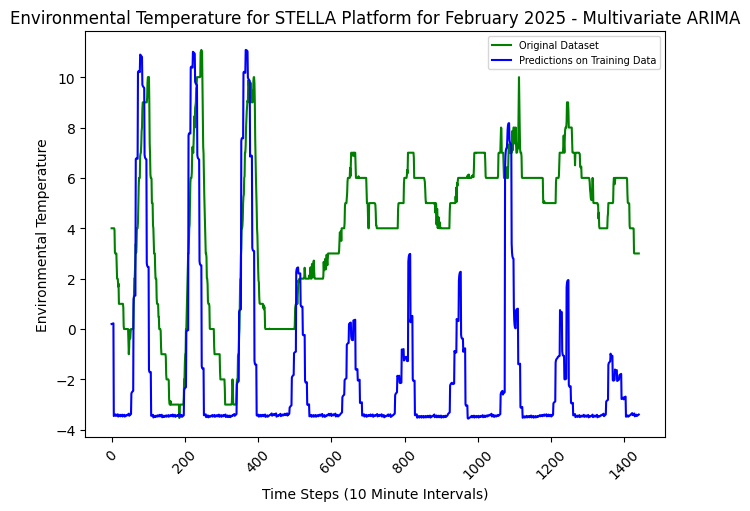

In [83]:
# Plot baseline and predictions

plt.plot(test_reshaped[:,0], 'g', label='Original Dataset')
plt.plot(predictions_arima_tf, 'b', label='Predictions on Training Data')
plt.legend(fontsize=7)

plt.xticks(rotation=45)  # Rotate x-axis labels for clarity
plt.tight_layout()  # Adjust layout to prevent clipping
plt.xlabel('Time Steps (10 Minute Intervals)')
plt.ylabel('Environmental Temperature')
plt.title('Environmental Temperature for STELLA Platform for February 2025 - Multivariate ARIMA')
plt.show()

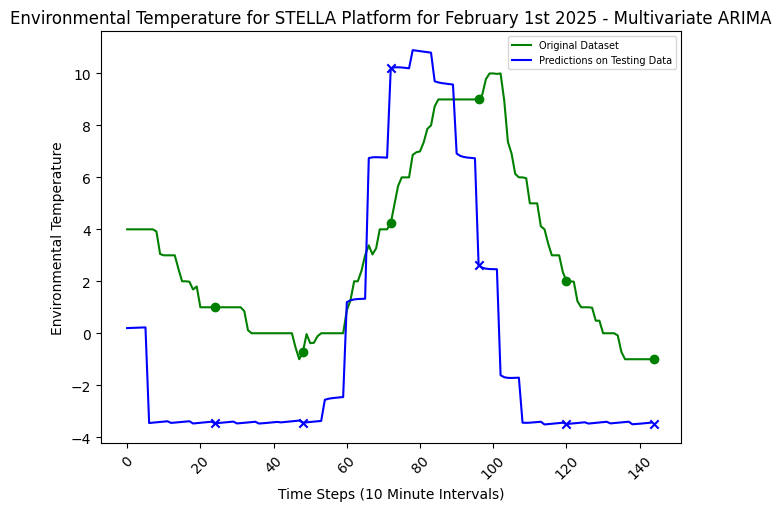

In [84]:
# Plot baseline and predictions for the first 168 timesteps
plt.plot(test_reshaped[:144,0], 'g', label='Original Dataset')  # Slice the first 168 timesteps
plt.plot(predictions_arima_tf[:144], 'b', label='Predictions on Testing Data')  # Slice the first 168 timesteps

# Define the tick positions and labels
tick_positions = [24, 48, 72, 96, 120, 144]
tick_labels = [str(tick) for tick in tick_positions]  # Convert to strings for labeling

# Get the y-values corresponding to the x-tick positions
original_y_values = test_reshaped[:,0][tick_positions]
predicted_y_values = predictions_arima_tf[tick_positions]

# Add pins (markers) at xtick locations
plt.scatter(tick_positions, original_y_values, color='g', marker='o', zorder=3)
plt.scatter(tick_positions, predicted_y_values, color='blue', marker='x', zorder=3)

# Customize the plot
plt.legend(fontsize=7)
plt.xticks(rotation=45)  # Rotate x-axis labels for clarity
plt.tight_layout()  # Adjust layout to prevent clipping
plt.xlabel('Time Steps (10 Minute Intervals)')
plt.ylabel('Environmental Temperature')
plt.title('Environmental Temperature for STELLA Platform for February 1st 2025 - Multivariate ARIMA')
plt.show()

# ARIMA Testing Without Dynamically Adjusted Intervals

In [85]:
df_resampled_pv_g = df_resampled[['Tamb']]

In [86]:
# Training data
train_df = df_resampled_pv_g[(df_resampled_pv_g.index >= '2024-09-01') & (df_resampled_pv_g.index < '2025-02-01')]

# Testing data
test_df = df_resampled_pv_g[(df_resampled_pv_g.index >= '2025-02-01')]

In [87]:
print(np.shape(train_df))
print(np.shape(test_df))

(22032, 1)
(1440, 1)


In [88]:
# Preparing dataset for LSTM training with dynamic time intervals

df_lstm_training = train_df.values
df_lstm_training = df_lstm_training.astype('float32')

df_lstm_testing = test_df.values
df_lstm_testing = df_lstm_testing.astype('float32')

# Normalize the dataset
# Normalizing the dataset is important for problems like the exploding gradient problem

scaler = MinMaxScaler(feature_range=(0, 1))
df_lstm_training = scaler.fit_transform(df_lstm_training)

scaler = MinMaxScaler(feature_range=(0, 1))
df_lstm_testing = scaler.fit_transform(df_lstm_testing)

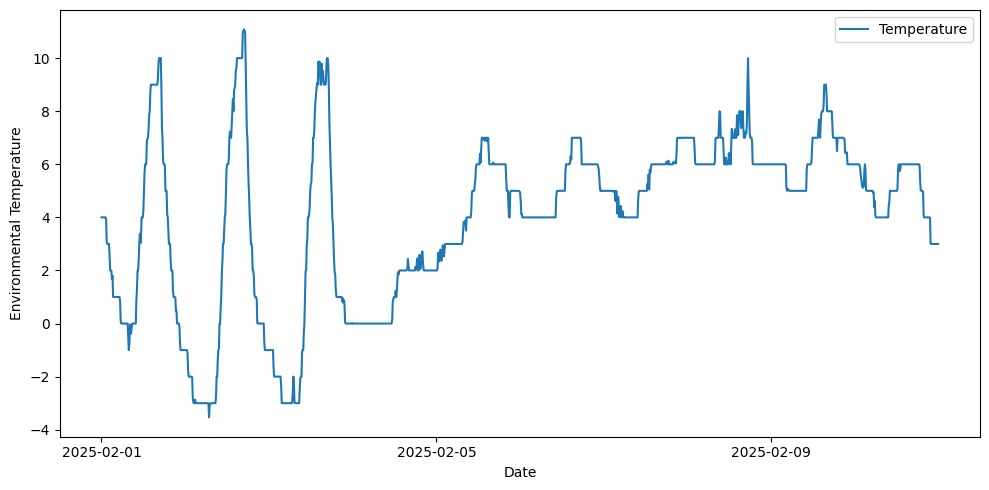

In [89]:
plt.figure(figsize=(10, 5))

plt.plot(test_df, label='Temperature')

# Set major x-axis locator to show only 4 dates
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator(minticks=4, maxticks=4))  # Force 4 labels
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Format as 'YYYY-MM-DD-HH-mm'
plt.xlabel("Date")
plt.ylabel("Environmental Temperature")
plt.legend()
plt.tight_layout()
plt.show()

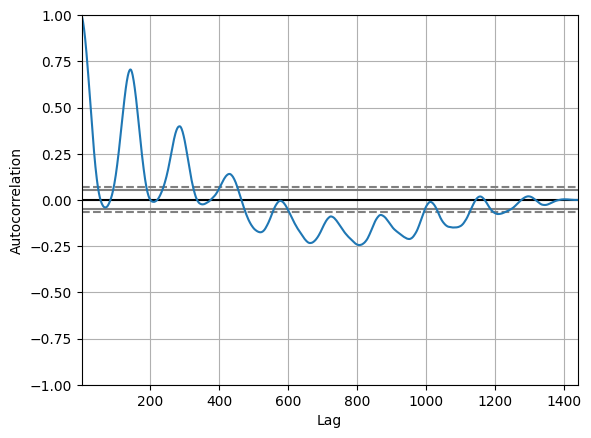

In [90]:
autocorrelation_plot(test_df)
plt.show()

                               SARIMAX Results                                
Dep. Variable:                   Tamb   No. Observations:                 1440
Model:                 ARIMA(6, 1, 0)   Log Likelihood                 -26.324
Date:                Thu, 17 Apr 2025   AIC                             66.649
Time:                        13:00:47   BIC                            103.551
Sample:                    02-01-2025   HQIC                            80.425
                         - 02-10-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2310      0.015     14.968      0.000       0.201       0.261
ar.L2          0.0393      0.017      2.287      0.022       0.006       0.073
ar.L3          0.0690      0.020      3.524      0.0

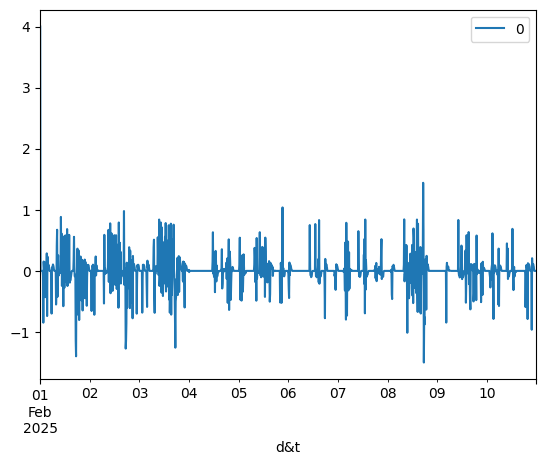

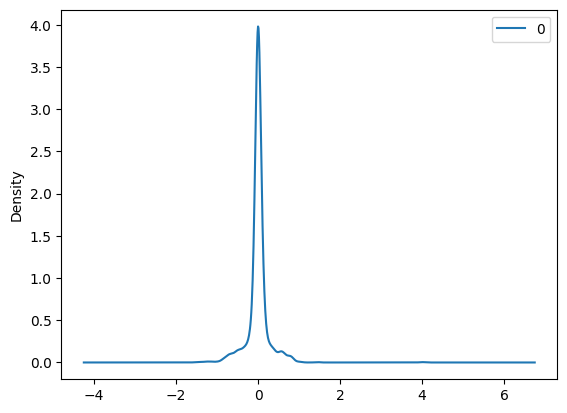

                 0
count  1440.000000
mean      0.002504
std       0.268012
min      -1.499820
25%      -0.013270
50%       0.000000
75%       0.049376
max       4.000000


In [91]:
# fit model
model_arima = ARIMA(test_df, order=(6,1,0))
model_fit = model_arima.fit()

# summary of fit model
print(model_fit.summary())

# line plot of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()

# density plot of residuals
residuals.plot(kind='kde')
plt.show()

# summary stats of residuals
print(residuals.describe())

In [92]:
# split into train and test sets
train_arima, test_arima = df_lstm_training, df_lstm_testing
history_arima = [x for x in train_arima]
predictions_arima = list()
rmse_per_prediction = []  # List to store RMSE per prediction

check = True
n_forecast = 6
n_steps = 6
percentage = 0

model_arima = ARIMA(history_arima, order=(n_steps,0,0))
model_fit = model_arima.fit()

# walk-forward validation
while check:

	# Forecast n_forecast steps ahead
	output_arima = model_fit.forecast(steps=n_forecast)
	yhat_arima = output_arima[:n_forecast]  # Get the predicted values

	# Store predictions
	predictions_arima.extend(yhat_arima)

	# Append actual observations to history
	actual_values = test_arima[percentage:percentage+n_forecast]  # Get actual values for next n timesteps
	history_arima.extend(actual_values)

	# Update the model with the new history (without refitting)
	model_fit = model_fit.append(actual_values, refit=False)

	# Compute RMSE for these 7 predictions
	multiple_rmse = np.sqrt(np.mean((yhat_arima - actual_values) ** 2))
	rmse_per_prediction.append(multiple_rmse)

	# Update completion percentage
	percentage += n_forecast  # Move ahead by n_forecast steps
	completion_rate = (percentage / len(test_arima)) * 100
	
	print(f'Predicted {n_forecast} steps ahead | RMSE={multiple_rmse:.6f} | {completion_rate:.0f}% complete')
	
	if (percentage >= len(test_arima)):
		check = False


Predicted 6 steps ahead | RMSE=0.259007 | 0% complete
Predicted 6 steps ahead | RMSE=0.047102 | 1% complete
Predicted 6 steps ahead | RMSE=0.039774 | 1% complete
Predicted 6 steps ahead | RMSE=0.044104 | 2% complete
Predicted 6 steps ahead | RMSE=0.007341 | 2% complete
Predicted 6 steps ahead | RMSE=0.047398 | 2% complete
Predicted 6 steps ahead | RMSE=0.014452 | 3% complete
Predicted 6 steps ahead | RMSE=0.032676 | 3% complete
Predicted 6 steps ahead | RMSE=0.072555 | 4% complete
Predicted 6 steps ahead | RMSE=0.009430 | 4% complete
Predicted 6 steps ahead | RMSE=0.138751 | 5% complete
Predicted 6 steps ahead | RMSE=0.030690 | 5% complete
Predicted 6 steps ahead | RMSE=0.100278 | 5% complete
Predicted 6 steps ahead | RMSE=0.082520 | 6% complete
Predicted 6 steps ahead | RMSE=0.051454 | 6% complete
Predicted 6 steps ahead | RMSE=0.002589 | 7% complete
Predicted 6 steps ahead | RMSE=0.056063 | 7% complete
Predicted 6 steps ahead | RMSE=0.199088 | 8% complete
Predicted 6 steps ahead | RM

In [93]:
# evaluate predictions hours for each day
predictions_arima = array(predictions_arima)

# Reshape `predictions` before inverse transform
n_samples = predictions_arima.shape
predictions_arima_tf = predictions_arima.reshape(n_samples[0] * 1, 1)

# Create a scaler for the target feature only
target_scaler = MinMaxScaler(feature_range=(0, 1))

# Initialize its internal parameters using the ones from the full scaler
# The scaler must belong to the targeted feature's column
target_scaler.min_ = scaler.min_[0].reshape(1,)
target_scaler.scale_ = scaler.scale_[0].reshape(1,)
target_scaler.data_min_ = scaler.data_min_[0].reshape(1,)
target_scaler.data_max_ = scaler.data_max_[0].reshape(1,)
target_scaler.data_range_ = scaler.data_range_[0].reshape(1,)

predictions_arima_tf = target_scaler.inverse_transform(predictions_arima_tf)

test_reshaped = scaler.inverse_transform(test_arima)

# evaluate forecasts
rmse = np.sqrt(mean_squared_error(test_reshaped, predictions_arima_tf))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.666


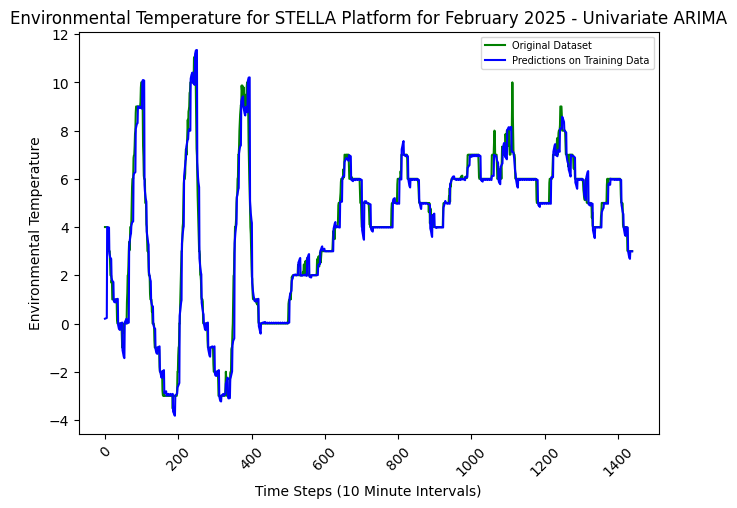

In [94]:
# Plot baseline and predictions

plt.plot(test_reshaped, 'g', label='Original Dataset')
plt.plot(predictions_arima_tf, 'b', label='Predictions on Training Data')
plt.legend(fontsize=7)

plt.xticks(rotation=45)  # Rotate x-axis labels for clarity
plt.tight_layout()  # Adjust layout to prevent clipping
plt.xlabel('Time Steps (10 Minute Intervals)')
plt.ylabel('Environmental Temperature')
plt.title('Environmental Temperature for STELLA Platform for February 2025 - Univariate ARIMA')
plt.show()

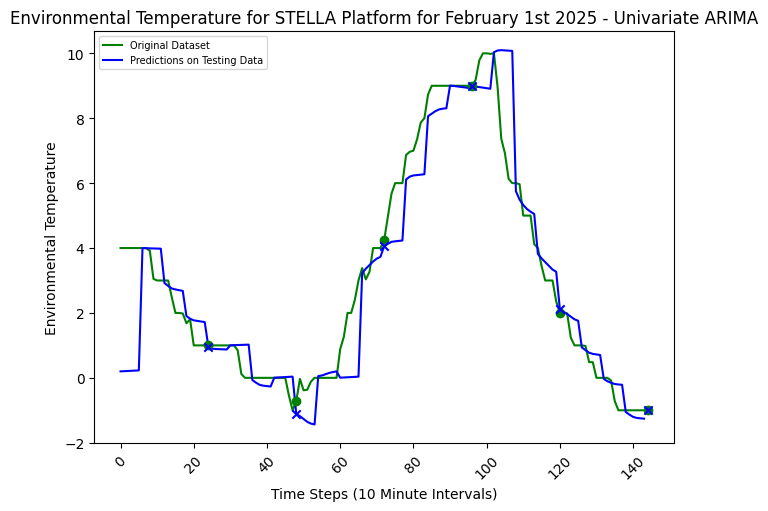

In [95]:
# Plot baseline and predictions for the first 168 timesteps
plt.plot(test_reshaped[:144], 'g', label='Original Dataset')  # Slice the first 168 timesteps
plt.plot(predictions_arima_tf[:144], 'b', label='Predictions on Testing Data')  # Slice the first 168 timesteps

# Define the tick positions and labels
tick_positions = [24, 48, 72, 96, 120, 144]
tick_labels = [str(tick) for tick in tick_positions]  # Convert to strings for labeling

# Get the y-values corresponding to the x-tick positions
original_y_values = test_reshaped[tick_positions]
predicted_y_values = predictions_arima_tf[tick_positions]

# Add pins (markers) at xtick locations
plt.scatter(tick_positions, original_y_values, color='g', marker='o', zorder=3)
plt.scatter(tick_positions, predicted_y_values, color='blue', marker='x', zorder=3)

# Customize the plot
plt.legend(fontsize=7)
plt.xticks(rotation=45)  # Rotate x-axis labels for clarity
plt.tight_layout()  # Adjust layout to prevent clipping
plt.xlabel('Time Steps (10 Minute Intervals)')
plt.ylabel('Environmental Temperature')
plt.title('Environmental Temperature for STELLA Platform for February 1st 2025 - Univariate ARIMA')
plt.show()

# RNN Implementation (Unfinished)
This is a basic RNN architecture implementation to compare its results with the LSTM model.

In [118]:
df_resampled_pv = df_resampled['Tpv']

In [119]:
# Training data
train_df = df_resampled_pv[(df_resampled_pv.index >= '2024-09-01') & (df_resampled_pv.index < '2025-02-01')]
train_df = train_df.to_frame()

# Testing data
test_df = df_resampled_pv[(df_resampled_pv.index >= '2025-02-01')]
test_df = test_df.to_frame()

In [120]:
print(np.shape(train_df))
print(np.shape(test_df))

(22032, 1)
(1440, 1)


In [121]:
# Preparing dataset for LSTM training with dynamic time intervals

df_lstm_training = train_df.values
df_lstm_training = df_lstm_training.astype('float32')

df_lstm_testing = test_df.values
df_lstm_testing = df_lstm_testing.astype('float32')

# Normalize the dataset
# Normalizing the dataset is important for problems like the exploding gradient problem

scaler = MinMaxScaler(feature_range=(0, 1))
df_lstm_training = scaler.fit_transform(df_lstm_training)

scaler = MinMaxScaler(feature_range=(0, 1))
df_lstm_testing = scaler.fit_transform(df_lstm_testing)

n_input = 1
n_output = 1
train, test = reframe_datasets(df_lstm_training, df_lstm_testing, n_input)

In [122]:
learning_rate = 0.0001    
nepoch = 10               
T = 5 # length of sequence
hidden_dim = 100         
output_dim = 1

bptt_truncate = 5
min_clip_value = -10
max_clip_value = 10

In [123]:
U = np.random.uniform(0, 1, (hidden_dim, 1)) # weight matrix for weights between input and hidden layers
W = np.random.uniform(0, 1, (hidden_dim, hidden_dim)) # weight matrix for shared weights in the RNN layer (hidden layer)
V = np.random.uniform(0, 1, (output_dim, hidden_dim)) # weight matrix for weights between hidden and output layers

In [124]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [125]:
train[0]

array([[0.5040129]], dtype=float32)

In [126]:
num_features = train.shape[1]  # Assuming train is (num_samples, num_features)

for epoch in range(nepoch):
    loss = 0.0

    for i in range(len(train) - 1):
        x = train[i]            # x: shape (num_features,)
        y = train[i + 1][0]     # y: scalar target value

        prev_s = np.zeros((hidden_dim, 1))
        s_list = {}             # store all hidden states
        s_list[-1] = np.copy(prev_s)

        x_inputs = []

        # Forward pass
        for t in range(T):
            new_input = x.reshape(-1, 1)  # (num_features, 1)
            x_inputs.append(new_input)

            mulu = np.dot(U, new_input)
            mulw = np.dot(W, prev_s)
            add = mulu + mulw
            s = sigmoid(add)
            s_list[t] = s
            prev_s = s

        mulv = np.dot(V, s)
        loss += (y - mulv[0][0]) ** 2 / 2

    print('Epoch: ', epoch + 1, ', Loss: ', loss, ', Val Loss: ', loss)

    # train model
    for i in range(train.shape[0] - 1):
        x = train[i]            # x: shape (num_features,)
        y = train[i + 1][0]     # y: scalar target value
    
        layers = []
        prev_s = np.zeros((hidden_dim, 1))
        dU = np.zeros(U.shape)
        dV = np.zeros(V.shape)
        dW = np.zeros(W.shape)
        
        dU_t = np.zeros(U.shape)
        dV_t = np.zeros(V.shape)
        dW_t = np.zeros(W.shape)
        
        dU_i = np.zeros(U.shape)
        dW_i = np.zeros(W.shape)
        
        # forward pass
        for t in range(T):
            new_input = np.zeros(x.shape)
            new_input[0] = x[0]
            mulu = np.dot(U, new_input)
            mulw = np.dot(W, prev_s)
            add = mulw + mulu
            s = sigmoid(add)
            mulv = np.dot(V, s)
            layers.append({'s':s, 'prev_s':prev_s})
            prev_s = s

        # derivative of pred
        dmulv = (mulv - y)
        
        # backward pass
        for t in range(T):
            dV_t = np.dot(dmulv, np.transpose(layers[t]['s']))
            dsv = np.dot(np.transpose(V), dmulv)
            
            ds = dsv
            dadd = add * (1 - add) * ds
            
            dmulw = dadd * np.ones_like(mulw)

            dprev_s = np.dot(np.transpose(W), dmulw)


            for i in range(t-1, max(-1, t-bptt_truncate-1), -1):
                ds = dsv + dprev_s
                dadd = add * (1 - add) * ds

                dmulw = dadd * np.ones_like(mulw)
                dmulu = dadd * np.ones_like(mulu)

                dW_i = np.dot(W, layers[t]['prev_s'])
                dprev_s = np.dot(np.transpose(W), dmulw)

                new_input = np.zeros(x.shape)
                new_input[0] = x[0]
                dU_i = np.dot(U, new_input)
                dx = np.dot(np.transpose(U), dmulu)

                dU_t += dU_i
                dW_t += dW_i
                
            dV += dV_t
            dU += dU_t
            dW += dW_t

            if dU.max() > max_clip_value:
                dU[dU > max_clip_value] = max_clip_value
            if dV.max() > max_clip_value:
                dV[dV > max_clip_value] = max_clip_value
            if dW.max() > max_clip_value:
                dW[dW > max_clip_value] = max_clip_value
                
            
            if dU.min() < min_clip_value:
                dU[dU < min_clip_value] = min_clip_value
            if dV.min() < min_clip_value:
                dV[dV < min_clip_value] = min_clip_value
            if dW.min() < min_clip_value:
                dW[dW < min_clip_value] = min_clip_value
        
        # update
        U -= learning_rate * dU
        V -= learning_rate * dV
        W -= learning_rate * dW

Epoch:  1 , Loss:  [26584808.] , Val Loss:  [26584808.]
Epoch:  2 , Loss:  [323.86188] , Val Loss:  [323.86188]
Epoch:  3 , Loss:  [323.8619] , Val Loss:  [323.8619]
Epoch:  4 , Loss:  [323.8619] , Val Loss:  [323.8619]
Epoch:  5 , Loss:  [323.8619] , Val Loss:  [323.8619]
Epoch:  6 , Loss:  [323.8619] , Val Loss:  [323.8619]
Epoch:  7 , Loss:  [323.8619] , Val Loss:  [323.8619]
Epoch:  8 , Loss:  [323.8619] , Val Loss:  [323.8619]
Epoch:  9 , Loss:  [323.8619] , Val Loss:  [323.8619]
Epoch:  10 , Loss:  [323.8619] , Val Loss:  [323.8619]


In [129]:
preds = []
for i in range(train.shape[0]-1):
    x = train[i]            # x: shape (num_features,)
    y = train[i + 1][0]     # y: scalar target value
    prev_s = np.zeros((hidden_dim, 1))
    # Forward pass
    for t in range(T):
        mulu = np.dot(U, x)
        mulw = np.dot(W, prev_s)
        add = mulw + mulu
        s = sigmoid(add)
        mulv = np.dot(V, s)
        prev_s = s

    preds.append(mulv)
    
preds = np.array(preds)

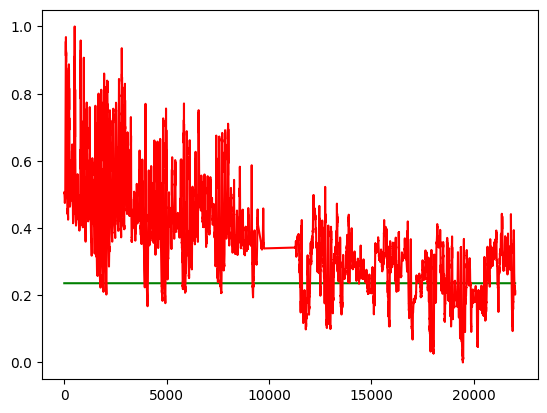

In [130]:
plt.plot(preds[:, 0], 'g')
plt.plot(train[:, 0], 'r')
plt.show()